# RUN

## Imports

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoProcessor, Llama4ForConditionalGeneration, default_data_collator, get_linear_schedule_with_warmup
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import torch
import os
import pandas as pd
import numpy as np
import random
random.seed(10)

## Parameters

In [ ]:

# Try Emotion Recognition in Conversation on EmoryNLP
# load csv from data/MELD
raw_train_df = pd.read_csv("data/MELD/train_sent_emo.csv")
raw_valid_df = pd.read_csv("data/MELD/dev_sent_emo.csv")
raw_test_df = pd.read_csv("data/MELD/test_sent_emo.csv")

#take only Utterance and Emotion columns
train_df = raw_train_df[['Dialogue_ID', 'Utterance', 'Emotion']]
valid_df = raw_valid_df[['Dialogue_ID', 'Utterance', 'Emotion']]
test_df = raw_test_df[['Dialogue_ID', 'Utterance', 'Emotion']]



model_name_or_path = "t5-base"
tokenizer_name_or_path = "t5-base"

num_virtual_tokens = 20
max_length = 256

do_train = True
do_eval = True

lr = 5e-3
label_balance_factor = 0.7
warmup_ratio=0.1
weight_decay=0.01
num_epochs = 50
batch_size = 20
logging_steps=250
eval_steps=250
save_steps=250
# logging_steps=60
# eval_steps=60
# save_steps=60
dataset_name = "MELD"
output_dir = f"results/{dataset_name}/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_subjects = len(raw_train_df['Emotion'].unique())+1
peft_padding_id = num_subjects*num_virtual_tokens


## integrate model class with dataset

### AbstractPrompt Classes

In [3]:
from peft import PeftModelForSeq2SeqLM, PeftConfig, PromptEncoderReparameterizationType, PromptEncoderConfig
from peft.tuners.prefix_tuning import PrefixEncoder
from peft.tuners.p_tuning import PromptEncoder
from peft.utils import _get_batch_size, TRANSFORMERS_MODELS_TO_PREFIX_TUNING_POSTPROCESS_MAPPING, map_cache_to_layer_device_map, PeftType, TaskType
from transformers import PreTrainedModel, DynamicCache, EncoderDecoderCache
from typing import Optional
import torch
import numpy as np
import warnings
from dataclasses import dataclass, field
import enum
from peft.mapping import MODEL_TYPE_TO_PEFT_MODEL_MAPPING
from typing import Union, List, Dict, Any


@dataclass
class AbstractPromptEncoderConfig(PromptEncoderConfig):
    """
    This is the configuration class to store the configuration of a [`PromptEncoder`].

    Args:
        encoder_reparameterization_type (Union[[`PromptEncoderReparameterizationType`], `str`]):
            The type of reparameterization to use.
        encoder_hidden_size (`int`): The hidden size of the prompt encoder.
        encoder_num_layers (`int`): The number of layers of the prompt encoder.
        encoder_dropout (`float`): The dropout probability of the prompt encoder.
    """

    num_subjects: int = field(
        default=8,
        metadata={"help": "The number of subjects of the prompt encoder"},
    )
    padding_idx: int = field(
        default=None,
        metadata={"help": "The padding index of the prompt encoder"},
    )
    def __post_init__(self):
        super().__post_init__()
        self.peft_type = PeftType.AP_Tuning


class AbstractPromptEncoder(PromptEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.num_subjects = config.num_subjects
        self.total_virtual_tokens = config.num_virtual_tokens * config.num_subjects * config.num_transformer_submodules
        if config.padding_idx is not None:
            self.padding_idx = config.padding_idx
        else:
            self.padding_idx = self.total_virtual_tokens
            self.total_virtual_tokens += 1

        # embedding
        self.embedding = torch.nn.Embedding(self.total_virtual_tokens, self.token_dim, padding_idx=self.padding_idx)
        if not config.inference_mode:
            if self.encoder_type == PromptEncoderReparameterizationType.LSTM:
                lstm_dropout = config.encoder_dropout
                num_layers = config.encoder_num_layers
                # LSTM
                self.lstm_head = torch.nn.LSTM(
                    input_size=self.input_size,
                    hidden_size=self.hidden_size,
                    num_layers=num_layers,
                    dropout=lstm_dropout,
                    bidirectional=True,
                    batch_first=True,
                )

                self.mlp_head = torch.nn.Sequential(
                    torch.nn.Linear(self.hidden_size * 2, self.hidden_size * 2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size * 2, self.output_size),
                )

            elif self.encoder_type == PromptEncoderReparameterizationType.MLP:
                encoder_num_layers_default = PromptEncoderConfig.encoder_num_layers
                if config.encoder_num_layers != encoder_num_layers_default:
                    warnings.warn(
                        f"for {self.encoder_type.value}, the argument `encoder_num_layers` is ignored. "
                        f"Exactly {encoder_num_layers_default} MLP layers are used."
                    )
                layers = [
                    torch.nn.Linear(self.input_size, self.hidden_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size, self.hidden_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.hidden_size, self.output_size),
                ]
                self.mlp_head = torch.nn.Sequential(*layers)

            else:
                raise ValueError("Prompt encoder type not recognized. Please use one of MLP (recommended) or LSTM.")


class AbstractPeftModelForSeq2SeqLM(PeftModelForSeq2SeqLM):
    def __init__(self, model: torch.nn.Module, peft_config: PeftConfig, adapter_name: str = "default", **kwargs):
        super().__init__(model, peft_config, adapter_name, **kwargs)
        self.model = model
        # self.peft_config = peft_config

    def _setup_prompt_encoder(self, adapter_name: str):
        config = self.peft_config[adapter_name]
        if not hasattr(self, "prompt_encoder"):
            self.prompt_encoder = torch.nn.ModuleDict({})
            self.prompt_tokens = {}
        transformer_backbone = None
        for name, module in self.base_model.named_children():
            for param in module.parameters():
                param.requires_grad = False
            if isinstance(module, PreTrainedModel):
                # Make sure to freeze Tranformers model
                if transformer_backbone is None:
                    transformer_backbone = module
                    self.transformer_backbone_name = name
        if transformer_backbone is None:
            transformer_backbone = self.base_model

        if config.num_transformer_submodules is None:
            config.num_transformer_submodules = 2 if config.task_type in [TaskType.SEQ_2_SEQ_LM, TaskType.ABS_SEQ_2_SEQ_LM] else 1

        # determine the word embeddings
        word_embeddings = None
        try:
            # First try to find the word embeddings based on the module name, this should work for models like Bert,
            # Roberta, Deberta, etc.
            word_embeddings = self.base_model.get_submodule("embeddings.word_embeddings")
        except AttributeError:
            pass

        if word_embeddings is None:
            # Word embeddings could not be determined. Next try to guess them by checking which parameter has the size
            # of the vocab.
            for named_param, value in list(transformer_backbone.named_parameters()):
                # for ZeRO-3, the tensor is sharded across accelerators and deepspeed modifies it to a tensor with shape
                # [0] the actual unsharded shape is stored in "ds_shape" attribute special handling is needed in case
                # the model is initialized in deepspeed.zero.Init() context or HfDeepSpeedConfig has been called before
                # For reference refer to issue: https://github.com/huggingface/peft/issues/996
                deepspeed_distributed_tensor_shape = getattr(value, "ds_shape", None)

                if value.shape[0] == self.base_model.config.vocab_size or (
                    deepspeed_distributed_tensor_shape is not None
                    and deepspeed_distributed_tensor_shape[0] == self.base_model.config.vocab_size
                ):
                    word_embeddings = transformer_backbone.get_submodule(named_param.replace(".weight", ""))
                    break

        self.word_embeddings = word_embeddings

        prompt_encoder = AbstractPromptEncoder(config)

        prompt_encoder = prompt_encoder.to(self.device)
        self.prompt_encoder.update(torch.nn.ModuleDict({adapter_name: prompt_encoder}))
        
        self.prompt_tokens[adapter_name] = torch.arange(
            config.num_virtual_tokens * config.num_subjects * config.num_transformer_submodules
        ).long()

    def get_prompt(self, batch_size: int, object_ids: Optional[torch.Tensor] = None, object_tokens: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Returns the virtual prompts to use for Peft. Only applicable when using a prompt learning method.

        The object_ids should be a tensor of shape 
        """
        peft_config = self.active_peft_config
        prompt_encoder = self.prompt_encoder[self.active_adapter]
        # arrange the prompt tokens according to the object id
        if object_tokens is not None:
            prompt_tokens = object_tokens
        elif object_ids is not None:
            object_ids = object_ids.view(batch_size, -1)
            prompt_tokens = (object_ids * peft_config.num_virtual_tokens)[:, :, None] + np.arange(peft_config.num_virtual_tokens)
            # set token id to padding id if it is out of range
            prompt_tokens[prompt_tokens > prompt_encoder.padding_idx] = prompt_encoder.padding_idx
            
        else:
            raise ValueError("object_ids is None, please provide object_ids for AbstractPeftModelForSeq2SeqLM")
        

        if peft_config.inference_mode:
            # prompts = prompt_encoder.embedding.weight
            # TODO: add support for inference mode
            pass
        else:
            prompts = prompt_encoder(prompt_tokens) # (batch_size, num_virtual_tokens, hidden_size)
        return prompts
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        inputs_embeds=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        decoder_inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        object_tokens=None,

        **kwargs,
    ):
        """
        args:
        object_ids: (batch_size, num_subjects) tensor of object ids. The object ids are used to select the prompt tokens. Not implemented
        object_tokens: (batch, lengths) tensor of object tokens. The object tokens are used to generate the prompt tokens. Should be the same length as prompt tokens.
        """
        peft_config = self.active_peft_config
        batch_size = _get_batch_size(input_ids, inputs_embeds)
        if decoder_attention_mask is not None:
            # concat prompt attention mask
            prefix_attention_mask = torch.ones(batch_size, peft_config.num_virtual_tokens).to(
                decoder_attention_mask.device
            )
            if peft_config.peft_type not in [PeftType.PROMPT_TUNING, PeftType.P_TUNING]:
                decoder_attention_mask = torch.cat((prefix_attention_mask, decoder_attention_mask), dim=1)

        if kwargs.get("position_ids", None) is not None:
            warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
            kwargs["position_ids"] = None
        if kwargs.get("token_type_ids", None) is not None:
            warnings.warn("Token type ids are not supported for parameter efficient tuning. Ignoring token type ids")
            kwargs["token_type_ids"] = None
        kwargs.update(
            {
                "attention_mask": attention_mask,
                "decoder_attention_mask": decoder_attention_mask,
                "labels": labels,
                "output_attentions": output_attentions,
                "output_hidden_states": output_hidden_states,
                "return_dict": return_dict,
            }
        )

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        prompts = self.get_prompt(batch_size=batch_size, object_tokens=object_tokens)
        prompts = prompts.to(inputs_embeds.dtype)

        if inputs_embeds.dim()==3:
            # inputs_embeds: (batch_size, sequence_len, hidden_size)
            # prompts: (batch_size, sequence_len, hidden_size)
            inputs_embeds = inputs_embeds+prompts

        return self.base_model(
            inputs_embeds=inputs_embeds,
            decoder_input_ids=decoder_input_ids,
            decoder_inputs_embeds=decoder_inputs_embeds,
            **kwargs,
        )
    

MODEL_TYPE_TO_PEFT_MODEL_MAPPING["ABS_SEQ_2_SEQ_LM"]=AbstractPeftModelForSeq2SeqLM

In [4]:


peft_config = AbstractPromptEncoderConfig(task_type=TaskType.ABS_SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20, num_subjects=num_subjects)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 2,018,304 || all params: 224,921,856 || trainable%: 0.8973


## Create dataset

In [5]:
# length of the dataset
print(f"train_df: {len(raw_train_df)}")
# check the label types in Emotion
print(raw_train_df['Emotion'].unique())
raw_train_df

train_df: 9989
['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


### Tokenize the data

In [6]:
text_column = "Utterance"
label_column = "Emotion"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
emotion_name_to_id = {name:i for i, name in enumerate(raw_train_df['Emotion'].unique())}
emotion_id_to_name = {i:name for i, name in enumerate(raw_train_df['Emotion'].unique())}
emotion_token_to_id = {tuple(tokenizer(name)["input_ids"]):i for i, name in enumerate(raw_train_df['Emotion'].unique())}
# tokenizer(emotion_id_to_name[emotions[j]])["input_ids"]
query_id = len(emotion_name_to_id)

def tokenize_function(examples):
    # print(examples)
    utterance = examples[text_column]
    emotion = examples[label_column]
    utterance_id = tokenizer(utterance, max_length=max_length, padding=False, truncation=False, return_tensors="pt")["input_ids"].view(-1)
    emotion_id = emotion_name_to_id[emotion]
    
    return {"Dialogue_ID":examples["Dialogue_ID"], "UtteranceID": utterance_id, "EmotionID": emotion_id}
    
dialogue_train_df = train_df.apply(
    tokenize_function,
    axis=1,
    result_type="expand",
)
dialogue_train_df = dialogue_train_df.groupby('Dialogue_ID').agg(list).reset_index()

dialogue_eval_df = valid_df.apply(
    tokenize_function,
    axis=1,
    result_type="expand",
)
dialogue_eval_df = dialogue_eval_df.groupby('Dialogue_ID').agg(list).reset_index()


### dataset transformation function

In [10]:

def dialogue_process_function(dialogue_data, utterance_name="UtteranceID", emotion_name="EmotionID", max_length=None, utterance_padding_token_id=0, emotion_padding_token_id=160, query_id=7, num_virtual_tokens=20):
    # print(examples)
    utterances_data = dialogue_data[utterance_name]
    emotions_data = dialogue_data[emotion_name]
    
    if max_length is None:
        max_length=0
        for utts in utterances_data:
            length = 0
            for utt in utts:
                length += utt.shape[-1]+num_virtual_tokens
            if length > max_length:
                max_length = length
    print(f"max_length: {max_length}")

    output = {
            "UtteranceID": [],
            "EmotionID": [],
            "AttentionMask": [],
            "Label": [],
        }
    
    for i, utterances in enumerate(tqdm(utterances_data)):
        emotions = emotions_data[i]
        begin_idx = 0
        last_utterance_unpad=None
        for j, utterance in enumerate(utterances):
            
            # print(f"data: {i}, utterance: {j}, begin_idx: {begin_idx}")

            new_utterance = torch.cat([ torch.full((num_virtual_tokens,), utterance_padding_token_id, dtype=torch.long), 
                                        utterance], dim=0) # preserve space for virtual tokens

            if new_utterance.shape[-1] > max_length or last_utterance_unpad is None:
                output_utterance = new_utterance[..., :max_length] # truncation
                begin_idx = j
            else:
                current_length = last_utterance_unpad.shape[-1] + new_utterance.shape[-1]
                length_to_trim = 0
                while current_length-length_to_trim > max_length:
                    length_to_trim += min(utterances[begin_idx].shape[-1]+num_virtual_tokens, max_length)
                    begin_idx+=1
                output_utterance = torch.cat([last_utterance_unpad[..., length_to_trim:], new_utterance], dim=0)
            output_attention_mask = torch.ones((output_utterance.shape[-1],), dtype=torch.long)
            last_utterance_unpad = output_utterance
            # pad the rest of the sequence
            output_utterance = torch.cat([output_utterance, torch.full((max_length - output_utterance.shape[-1],), utterance_padding_token_id, dtype=torch.long)], dim=0)
            output_attention_mask = torch.cat([output_attention_mask, torch.zeros((max_length - output_attention_mask.shape[-1],), dtype=torch.long)], dim=0)


            
            emotion = torch.tensor(emotions[begin_idx:j]+[query_id])
            output_label = tokenizer(emotion_id_to_name[emotions[j]])["input_ids"]

            prompt_tokens = (emotion * num_virtual_tokens).unsqueeze(-1).view(-1,1) + np.arange(num_virtual_tokens) if emotions[begin_idx:j] else torch.tensor([])

            # concatenate the prompt tokens and pad them in between to match the length of the utterance
            output_emotion = torch.tensor([])
            emotion_idx = begin_idx
            padding_max_length = max_length-num_virtual_tokens
            for pt in prompt_tokens:
                pt = torch.cat([pt, torch.full((min(utterances[emotion_idx].shape[-1], padding_max_length),), emotion_padding_token_id, dtype=torch.long)], dim=0)
                output_emotion = torch.cat([output_emotion, pt], dim=0)
                emotion_idx+=1
            # set token id to padding id if it is out of range
            output_emotion[output_emotion > emotion_padding_token_id] = emotion_padding_token_id
            output_prompt = torch.cat([output_emotion, torch.full((max_length - output_emotion.shape[-1],), emotion_padding_token_id, dtype=torch.long)], dim=0)
            output_prompt = output_prompt.to(torch.long)

            # if output_utterance.shape[-1] != max_length or output_emotion.shape[-1] != max_length, raise ValueError
            if output_utterance.shape[-1] != max_length:
                raise ValueError(f"output_utterance shape: {output_utterance.shape[-1]} != max_length: {max_length}")
            if output_prompt.shape[-1] != max_length:
                raise ValueError(f"output_emotion shape: {output_prompt.shape[-1]} != max_length: {max_length}")

            output["UtteranceID"].append(output_utterance)
            output["EmotionID"].append(output_prompt)
            output["AttentionMask"].append(output_attention_mask)
            output["Label"].append(output_label)
    return output


utterance_padding_token_id = tokenizer.pad_token_id
emotion_padding_token_id = model.prompt_encoder["default"].padding_idx

dialogue_train_df_processed = dialogue_process_function(dialogue_train_df, max_length=max_length, utterance_padding_token_id=utterance_padding_token_id, emotion_padding_token_id=emotion_padding_token_id, query_id=query_id, num_virtual_tokens=num_virtual_tokens)
dialogue_train_df_processed = Dataset.from_dict(dialogue_train_df_processed).with_format("torch")
dialogue_eval_df_processed = dialogue_process_function(dialogue_eval_df, max_length=max_length, utterance_padding_token_id=utterance_padding_token_id, emotion_padding_token_id=emotion_padding_token_id, query_id=query_id, num_virtual_tokens=num_virtual_tokens)
dialogue_eval_df_processed = Dataset.from_dict(dialogue_eval_df_processed).with_format("torch")


train_dataloader = DataLoader(
    dataset=dialogue_train_df_processed,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=default_data_collator,
)
eval_dataloader = DataLoader(
    dataset=dialogue_eval_df_processed,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=default_data_collator,
)


max_length: 256


  0%|          | 0/1038 [00:00<?, ?it/s]

C:\Users\cheng\AppData\Local\Temp\ipykernel_16476\3514248438.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  prompt_tokens = (emotion * num_virtual_tokens).unsqueeze(-1).view(-1,1) + np.arange(num_virtual_tokens) if emotions[begin_idx:j] else torch.tensor([])


max_length: 256


  0%|          | 0/114 [00:00<?, ?it/s]

In [8]:
# check the proportion of each label
from math import sqrt
num_labels={tokens:0 for tokens in emotion_token_to_id}
for data in dialogue_train_df_processed:
    label = tuple(data["Label"].tolist())
    num_labels[label]+=1

num_sample_min = min(num_labels.values())
CELoss_weight = torch.ones(model.base_model.config.vocab_size)
for tokens in num_labels:
    id = emotion_token_to_id[tokens]
    name = emotion_id_to_name[id]
    for token in tokens[:-1]:
        CELoss_weight[token] = (num_sample_min/num_labels[tokens])**(label_balance_factor)
    print(f"{name}: {num_labels[tokens]} ({num_labels[tokens]*100/len(dialogue_train_df_processed)}%) weight: {(num_sample_min/num_labels[tokens])**(label_balance_factor)}")
CELoss_weight = CELoss_weight.to(device)

neutral: 4710 (47.15186705375913%) weight: 0.1344558556559341
surprise: 1205 (12.063269596556212%) weight: 0.3491430673116403
fear: 268 (2.682951246371008%) weight: 1.0
sadness: 683 (6.837521273400741%) weight: 0.5195171194179858
joy: 1743 (17.44919411352488%) weight: 0.269641158777824
disgust: 271 (2.7129842827109822%) weight: 0.992237992915699
anger: 1109 (11.102212433677044%) weight: 0.37003454797861995


## Train

In [ ]:
from transformers import DataCollatorWithPadding
class DataCollatorWithPrompt(DataCollatorWithPadding):
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        return features

    

In [ ]:
# training with huggingface trainer
# not applicable, as we need input for prompt encoder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
output_dir = f"results/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    do_train=do_train,
    do_eval=do_eval,

    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    warmup_ratio=warmup_ratio,
    weight_decay=weight_decay,
    num_train_epochs=num_epochs,
    
    logging_strategy="steps",
    logging_steps=logging_steps,
    eval_strategy="steps",
    eval_steps = eval_steps,
    save_strategy="steps",
    save_steps=save_steps,
    save_total_limit=2,

    predict_with_generate=True,
    load_best_model_at_end=True,
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dialogue_train_df_processed,
    eval_dataset=dialogue_eval_df_processed,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPrompt,
)


In [10]:
from torch.nn import CrossEntropyLoss
# setup custom training loop
output_dir = f"results/{model_name_or_path.split('/')[-1]}-peft/lr_{lr}-epochs_{num_epochs}-batch_{batch_size}"
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(num_training_steps * warmup_ratio),
    num_training_steps=num_training_steps,
)
# move model to device
model.to(device)
# training loop
model.train()
cur_step = 0
best_F1_score = 0
train_loss_list = []
eval_loss_list = []
eval_F1_score_list_macro = []
eval_F1_score_list_weighted = []
for epoch in trange(num_epochs, desc=" epoch loop", position=0):
    for batch in tqdm(train_dataloader, desc=" inner loop", position=1, leave=False):
        # move batch to device
        batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        # forward pass
        outputs = model(
            input_ids=batch["UtteranceID"],
            attention_mask=batch["AttentionMask"],
            object_tokens=batch["EmotionID"],
            labels=batch["Label"],
        )

        # loss = outputs.loss
        loss = None
        lm_logits = outputs.logits
        labels = batch["Label"]
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight = CELoss_weight, ignore_index=-100)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))

        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        train_loss_list.append(loss.item())

        # if cur_step % logging_steps == 0:
        #     print(f"Step {cur_step}, Loss: {loss.item()}")


        # evaluation
        if do_eval and cur_step % eval_steps == eval_steps - 1:
            model.eval()
            # calculate the macro F1 score

            eval_loss = 0.0
            num_prediction = {label_id: 0 for label_id in range(len(emotion_token_to_id))}
            num_label = {label_id: 0 for label_id in range(len(emotion_token_to_id))}
            num_true_positive = {label_id: 0 for label_id in range(len(emotion_token_to_id))}

            for eval_batch in tqdm(eval_dataloader, desc="Eval loop", position=2, leave=False):
                eval_batch = {k: v.to(device) for k, v in eval_batch.items() if isinstance(v, torch.Tensor)}
                with torch.no_grad():
                    eval_outputs = model(
                        input_ids=eval_batch["UtteranceID"],
                        attention_mask=eval_batch["AttentionMask"],
                        object_tokens=eval_batch["EmotionID"],
                        labels=eval_batch["Label"],
                    )
                    loss = None
                    lm_logits = outputs.logits
                    labels = batch["Label"]
                    if labels is not None:
                        loss_fct = CrossEntropyLoss(weight = CELoss_weight, ignore_index=-100)
                        loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
                    eval_loss += loss

                # calculate precision and recall
                eval_predictions = eval_outputs.logits.argmax(dim=-1).tolist()
                eval_labels = eval_batch["Label"].tolist()
                # print(eval_outputs["logits"].shape)
                # print(eval_predictions)
                # print(eval_labels)

                # sweep through the predictions and labels
                for i in range(len(eval_predictions)):
                    pred = tuple(eval_predictions[i])
                    label = tuple(eval_labels[i])
                    if pred in emotion_token_to_id:
                        num_prediction[emotion_token_to_id[pred]] += 1
                    num_label[emotion_token_to_id[label]] += 1
                    if pred == label:
                        num_true_positive[emotion_token_to_id[pred]] += 1
            recall = {label_id: num_true_positive[label_id] / num_label[label_id] if num_label[label_id] > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            precision = {label_id: num_true_positive[label_id] / num_prediction[label_id] if num_prediction[label_id] > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            F1_score = {label_id: 2 * precision[label_id] * recall[label_id] / (precision[label_id] + recall[label_id]) if (precision[label_id] + recall[label_id]) > 0 else 0 for label_id in range(len(emotion_token_to_id))}
            macro_F1_score = np.mean(list(F1_score.values()))
            weighted_F1_score = np.average(list(F1_score.values()), weights=list(num_label.values()))
            print(f"cur_step: {cur_step+1}")
            print("  loss:", eval_loss / len(eval_dataloader))
            print("  recall:", recall)
            print("  precision:", precision)
            print("  F1_score:", F1_score)
            print("  macro_F1_score:", macro_F1_score)
            print("  weighted_F1_score:", weighted_F1_score)
            print("==========================================================================================")
            eval_loss_list.append(eval_loss.item() / len(eval_dataloader))
            eval_F1_score_list_macro.append(macro_F1_score)
            eval_F1_score_list_weighted.append(weighted_F1_score)

            # save the model if the F1 score is better than the best F1 score
            if weighted_F1_score > best_F1_score:
                best_F1_score = weighted_F1_score
                model.save_pretrained(output_dir)
                tokenizer.save_pretrained(output_dir)
                print(f"Model saved to {output_dir} with F1 score: {best_F1_score}")

            model.train()

        cur_step += 1



 epoch loop:   0%|          | 0/50 [00:00<?, ?it/s]

 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 250
  loss: tensor(0.9357, device='cuda:0')
  recall: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.7727272727272727, 6: 0.30718954248366015}
  precision: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.02135678391959799, 6: 0.23618090452261306}
  F1_score: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.04156479217603912, 6: 0.26704545454545453}
  macro_F1_score: 0.044087178103070515
  weighted_F1_score: 0.03766670872256754
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.03766670872256754


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 500
  loss: tensor(0.3410, device='cuda:0')
  recall: {0: 0.12340425531914893, 1: 0.006666666666666667, 2: 0.0, 3: 0.6846846846846847, 4: 0.4785276073619632, 5: 0.0, 6: 0.16339869281045752}
  precision: {0: 0.6744186046511628, 1: 0.1111111111111111, 2: 0, 3: 0.15384615384615385, 4: 0.2025974025974026, 5: 0, 6: 0.18518518518518517}
  F1_score: {0: 0.20863309352517986, 1: 0.012578616352201259, 2: 0, 3: 0.2512396694214876, 4: 0.28467153284671537, 5: 0, 6: 0.1736111111111111}
  macro_F1_score: 0.13296200332238503
  weighted_F1_score: 0.18106033324568482
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.18106033324568482


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 750
  loss: tensor(0.6250, device='cuda:0')
  recall: {0: 0.6595744680851063, 1: 0.0, 2: 0.0, 3: 0.15315315315315314, 4: 0.049079754601226995, 5: 0.0, 6: 0.6862745098039216}
  precision: {0: 0.4725609756097561, 1: 0, 2: 0, 3: 0.40476190476190477, 4: 0.5333333333333333, 5: 0, 6: 0.26515151515151514}
  F1_score: {0: 0.5506216696269982, 1: 0, 2: 0, 3: 0.2222222222222222, 4: 0.0898876404494382, 5: 0, 6: 0.3825136612021858}
  macro_F1_score: 0.17789217050012063
  weighted_F1_score: 0.3215826212340385
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.3215826212340385


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1000
  loss: tensor(0.6679, device='cuda:0')
  recall: {0: 0.5170212765957447, 1: 0.05333333333333334, 2: 0.0, 3: 0.46846846846846846, 4: 0.06134969325153374, 5: 0.045454545454545456, 6: 0.5686274509803921}
  precision: {0: 0.5203426124197003, 1: 0.5, 2: 0, 3: 0.18309859154929578, 4: 0.18181818181818182, 5: 0.05555555555555555, 6: 0.32342007434944237}
  F1_score: {0: 0.5186766275346852, 1: 0.0963855421686747, 2: 0, 3: 0.26329113924050634, 4: 0.09174311926605504, 5: 0.049999999999999996, 6: 0.4123222748815165}
  macro_F1_score: 0.20463124329877683
  weighted_F1_score: 0.3305686196749671
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.3305686196749671


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1250
  loss: tensor(0.5375, device='cuda:0')
  recall: {0: 0.251063829787234, 1: 0.1, 2: 0.075, 3: 0.36036036036036034, 4: 0.018404907975460124, 5: 0.7272727272727273, 6: 0.41830065359477125}
  precision: {0: 0.592964824120603, 1: 0.2, 2: 0.03, 3: 0.37037037037037035, 4: 0.6, 5: 0.03285420944558522, 6: 0.4740740740740741}
  F1_score: {0: 0.35276532137518685, 1: 0.13333333333333333, 2: 0.04285714285714286, 3: 0.365296803652968, 4: 0.03571428571428572, 5: 0.06286836935166994, 6: 0.4444444444444445}
  macro_F1_score: 0.20532567153271875
  weighted_F1_score: 0.2734593910399173


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1500
  loss: tensor(0.6634, device='cuda:0')
  recall: {0: 0.7531914893617021, 1: 0.006666666666666667, 2: 0.0, 3: 0.25225225225225223, 4: 0.07975460122699386, 5: 0.045454545454545456, 6: 0.5163398692810458}
  precision: {0: 0.46153846153846156, 1: 0.125, 2: 0, 3: 0.417910447761194, 4: 0.2708333333333333, 5: 0.037037037037037035, 6: 0.4114583333333333}
  F1_score: {0: 0.5723524656426839, 1: 0.012658227848101267, 2: 0, 3: 0.3146067415730337, 4: 0.12322274881516587, 5: 0.04081632653061224, 6: 0.45797101449275357}
  macro_F1_score: 0.21737536070033578
  weighted_F1_score: 0.35787067069596057
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.35787067069596057


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 1750
  loss: tensor(0.2632, device='cuda:0')
  recall: {0: 0.6063829787234043, 1: 0.04666666666666667, 2: 0.325, 3: 0.15315315315315314, 4: 0.2147239263803681, 5: 0.0, 6: 0.5294117647058824}
  precision: {0: 0.5191256830601093, 1: 0.1206896551724138, 2: 0.1511627906976744, 3: 0.425, 4: 0.2692307692307692, 5: 0.0, 6: 0.3306122448979592}
  F1_score: {0: 0.5593719332679097, 1: 0.0673076923076923, 2: 0.20634920634920634, 3: 0.22516556291390724, 4: 0.2389078498293515, 5: 0, 6: 0.40703517587939697}
  macro_F1_score: 0.24344820293535202
  weighted_F1_score: 0.36741809707052786
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.36741809707052786


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2000
  loss: tensor(0.2834, device='cuda:0')
  recall: {0: 0.5829787234042553, 1: 0.26, 2: 0.0, 3: 0.24324324324324326, 4: 0.15950920245398773, 5: 0.0, 6: 0.5359477124183006}
  precision: {0: 0.524904214559387, 1: 0.18660287081339713, 2: 0, 3: 0.38028169014084506, 4: 0.28888888888888886, 5: 0, 6: 0.3778801843317972}
  F1_score: {0: 0.5524193548387096, 1: 0.21727019498607245, 2: 0, 3: 0.2967032967032967, 4: 0.20553359683794467, 5: 0, 6: 0.44324324324324316}
  macro_F1_score: 0.24502424094418093
  weighted_F1_score: 0.38456256488455504
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.38456256488455504


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2250
  loss: tensor(0.6074, device='cuda:0')
  recall: {0: 0.8723404255319149, 1: 0.0, 2: 0.05, 3: 0.15315315315315314, 4: 0.12883435582822086, 5: 0.0, 6: 0.28104575163398693}
  precision: {0: 0.45555555555555555, 1: 0, 2: 0.16666666666666666, 3: 0.4358974358974359, 4: 0.26582278481012656, 5: 0.0, 6: 0.5657894736842105}
  F1_score: {0: 0.5985401459854015, 1: 0, 2: 0.07692307692307691, 3: 0.22666666666666668, 4: 0.17355371900826447, 5: 0, 6: 0.37554585152838427}
  macro_F1_score: 0.20731849430168484
  weighted_F1_score: 0.35644595416794567


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2500
  loss: tensor(0.3782, device='cuda:0')
  recall: {0: 0.014893617021276596, 1: 0.5533333333333333, 2: 0.3, 3: 0.36036036036036034, 4: 0.12883435582822086, 5: 0.13636363636363635, 6: 0.3790849673202614}
  precision: {0: 0.5833333333333334, 1: 0.14821428571428572, 2: 0.21052631578947367, 3: 0.3053435114503817, 4: 0.2625, 5: 0.05454545454545454, 6: 0.48739495798319327}
  F1_score: {0: 0.029045643153526972, 1: 0.23380281690140842, 2: 0.24742268041237106, 3: 0.3305785123966943, 4: 0.17283950617283955, 5: 0.07792207792207792, 6: 0.42647058823529405}
  macro_F1_score: 0.2168688321706018
  weighted_F1_score: 0.17173139957651523


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 2750
  loss: tensor(0.4442, device='cuda:0')
  recall: {0: 0.13617021276595745, 1: 0.7733333333333333, 2: 0.15, 3: 0.0, 4: 0.0, 5: 0.13636363636363635, 6: 0.3660130718954248}
  precision: {0: 0.6213592233009708, 1: 0.14146341463414633, 2: 0.2222222222222222, 3: 0, 4: 0, 5: 0.06818181818181818, 6: 0.48695652173913045}
  F1_score: {0: 0.22338568935427575, 1: 0.23917525773195872, 2: 0.1791044776119403, 3: 0, 4: 0, 5: 0.0909090909090909, 6: 0.417910447761194}
  macro_F1_score: 0.1643549947669228
  weighted_F1_score: 0.19294142494882208


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3000
  loss: tensor(0.4538, device='cuda:0')
  recall: {0: 0.0, 1: 0.0, 2: 0.425, 3: 0.3963963963963964, 4: 0.7116564417177914, 5: 0.0, 6: 0.49673202614379086}
  precision: {0: 0, 1: 0, 2: 0.1574074074074074, 3: 0.2913907284768212, 4: 0.1856, 5: 0.0, 6: 0.34234234234234234}
  F1_score: {0: 0, 1: 0, 2: 0.22972972972972974, 3: 0.33587786259541985, 4: 0.2944162436548223, 5: 0, 6: 0.4053333333333333}
  macro_F1_score: 0.18076530990190073
  weighted_F1_score: 0.1410978175410431


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3250
  loss: tensor(0.5582, device='cuda:0')
  recall: {0: 0.3617021276595745, 1: 0.05333333333333334, 2: 0.4, 3: 0.036036036036036036, 4: 0.49693251533742333, 5: 0.13636363636363635, 6: 0.5163398692810458}
  precision: {0: 0.5448717948717948, 1: 0.13114754098360656, 2: 0.1839080459770115, 3: 0.8, 4: 0.2219178082191781, 5: 0.05263157894736842, 6: 0.35585585585585583}
  F1_score: {0: 0.43478260869565216, 1: 0.07582938388625593, 2: 0.25196850393700787, 3: 0.06896551724137931, 4: 0.3068181818181819, 5: 0.0759493670886076, 6: 0.4213333333333333}
  macro_F1_score: 0.233663842285774
  weighted_F1_score: 0.31524111447563685


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3500
  loss: tensor(0.3066, device='cuda:0')
  recall: {0: 0.6638297872340425, 1: 0.0, 2: 0.2, 3: 0.4594594594594595, 4: 0.08588957055214724, 5: 0.18181818181818182, 6: 0.5294117647058824}
  precision: {0: 0.5073170731707317, 1: 0, 2: 0.38095238095238093, 3: 0.3167701863354037, 4: 0.32558139534883723, 5: 0.07407407407407407, 6: 0.3767441860465116}
  F1_score: {0: 0.5751152073732718, 1: 0, 2: 0.2622950819672132, 3: 0.375, 4: 0.1359223300970874, 5: 0.10526315789473684, 6: 0.4402173913043478}
  macro_F1_score: 0.27054473837666526
  weighted_F1_score: 0.3735305147819666


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 3750
  loss: tensor(0.4175, device='cuda:0')
  recall: {0: 0.04893617021276596, 1: 0.21333333333333335, 2: 0.175, 3: 0.26126126126126126, 4: 0.4662576687116564, 5: 0.045454545454545456, 6: 0.6143790849673203}
  precision: {0: 0.6388888888888888, 1: 0.20512820512820512, 2: 0.25925925925925924, 3: 0.28431372549019607, 4: 0.20540540540540542, 5: 0.16666666666666666, 6: 0.22815533980582525}
  F1_score: {0: 0.0909090909090909, 1: 0.20915032679738563, 2: 0.208955223880597, 3: 0.27230046948356806, 4: 0.2851782363977486, 5: 0.07142857142857144, 6: 0.3327433628318584}
  macro_F1_score: 0.21009504024697429
  weighted_F1_score: 0.1908463466477155


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4000
  loss: tensor(0.5128, device='cuda:0')
  recall: {0: 0.41914893617021276, 1: 0.0, 2: 0.325, 3: 0.44144144144144143, 4: 0.26380368098159507, 5: 0.0, 6: 0.5359477124183006}
  precision: {0: 0.5338753387533876, 1: 0, 2: 0.13541666666666666, 3: 0.23444976076555024, 4: 0.2471264367816092, 5: 0, 6: 0.31417624521072796}
  F1_score: {0: 0.4696066746126341, 1: 0, 2: 0.19117647058823525, 3: 0.30625, 4: 0.2551928783382789, 5: 0, 6: 0.3961352657004831}
  macro_F1_score: 0.2311944698913759
  weighted_F1_score: 0.3287295588032289


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4250
  loss: tensor(0.4127, device='cuda:0')
  recall: {0: 0.14680851063829786, 1: 0.24666666666666667, 2: 0.375, 3: 0.5135135135135135, 4: 0.39263803680981596, 5: 0.18181818181818182, 6: 0.38562091503267976}
  precision: {0: 0.5702479338842975, 1: 0.17289719626168223, 2: 0.1744186046511628, 3: 0.2676056338028169, 4: 0.23703703703703705, 5: 0.06060606060606061, 6: 0.4244604316546763}
  F1_score: {0: 0.233502538071066, 1: 0.20329670329670327, 2: 0.23809523809523814, 3: 0.35185185185185186, 4: 0.2956120092378753, 5: 0.09090909090909091, 6: 0.40410958904109595}
  macro_F1_score: 0.2596252886432745
  weighted_F1_score: 0.27126563399128306


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4500
  loss: tensor(0.3810, device='cuda:0')
  recall: {0: 0.20638297872340425, 1: 0.06, 2: 0.075, 3: 0.4864864864864865, 4: 0.558282208588957, 5: 0.09090909090909091, 6: 0.5424836601307189}
  precision: {0: 0.5843373493975904, 1: 0.2727272727272727, 2: 0.3, 3: 0.2727272727272727, 4: 0.20967741935483872, 5: 0.08333333333333333, 6: 0.3401639344262295}
  F1_score: {0: 0.3050314465408805, 1: 0.09836065573770492, 2: 0.12, 3: 0.3495145631067961, 4: 0.304857621440536, 5: 0.08695652173913043, 6: 0.41813602015113344}
  macro_F1_score: 0.24040811838802592
  weighted_F1_score: 0.28610878412616375


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 4750
  loss: tensor(0.4344, device='cuda:0')
  recall: {0: 0.30851063829787234, 1: 0.19333333333333333, 2: 0.3, 3: 0.4864864864864865, 4: 0.25766871165644173, 5: 0.13636363636363635, 6: 0.5098039215686274}
  precision: {0: 0.5776892430278885, 1: 0.24369747899159663, 2: 0.19047619047619047, 3: 0.25961538461538464, 4: 0.22340425531914893, 5: 0.057692307692307696, 6: 0.34210526315789475}
  F1_score: {0: 0.4022191400832178, 1: 0.21561338289962823, 2: 0.23300970873786406, 3: 0.3385579937304075, 4: 0.2393162393162393, 5: 0.08108108108108107, 6: 0.40944881889763785}
  macro_F1_score: 0.2741780521065823
  weighted_F1_score: 0.335187853030943


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5000
  loss: tensor(0.4581, device='cuda:0')
  recall: {0: 0.3127659574468085, 1: 0.04666666666666667, 2: 0.4, 3: 0.5225225225225225, 4: 0.3496932515337423, 5: 0.18181818181818182, 6: 0.5098039215686274}
  precision: {0: 0.5903614457831325, 1: 0.22580645161290322, 2: 0.17777777777777778, 3: 0.23868312757201646, 4: 0.23265306122448978, 5: 0.11428571428571428, 6: 0.3611111111111111}
  F1_score: {0: 0.40890125173852576, 1: 0.07734806629834255, 2: 0.24615384615384614, 3: 0.327683615819209, 4: 0.2794117647058823, 5: 0.14035087719298245, 6: 0.42276422764227634}
  macro_F1_score: 0.2718019499358663
  weighted_F1_score: 0.3276100966983925


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5250
  loss: tensor(0.4703, device='cuda:0')
  recall: {0: 0.3723404255319149, 1: 0.06666666666666667, 2: 0.35, 3: 0.23423423423423423, 4: 0.4110429447852761, 5: 0.18181818181818182, 6: 0.47058823529411764}
  precision: {0: 0.5537974683544303, 1: 0.21739130434782608, 2: 0.1590909090909091, 3: 0.3058823529411765, 4: 0.23426573426573427, 5: 0.058823529411764705, 6: 0.32727272727272727}
  F1_score: {0: 0.44529262086514, 1: 0.10204081632653061, 2: 0.21875, 3: 0.26530612244897955, 4: 0.2984409799554566, 5: 0.08888888888888888, 6: 0.386058981233244}
  macro_F1_score: 0.25782548710260567
  weighted_F1_score: 0.33585310483716274


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5500
  loss: tensor(0.3757, device='cuda:0')
  recall: {0: 0.0, 1: 0.0, 2: 0.475, 3: 0.21621621621621623, 4: 0.6993865030674846, 5: 0.13636363636363635, 6: 0.5228758169934641}
  precision: {0: 0, 1: 0, 2: 0.12418300653594772, 3: 0.36363636363636365, 4: 0.1859706362153344, 5: 0.08333333333333333, 6: 0.33195020746887965}
  F1_score: {0: 0, 1: 0, 2: 0.19689119170984457, 3: 0.27118644067796616, 4: 0.2938144329896907, 5: 0.10344827586206896, 6: 0.4060913705583756}
  macro_F1_score: 0.18163310168542085
  weighted_F1_score: 0.13550670597417908


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 5750
  loss: tensor(0.5123, device='cuda:0')
  recall: {0: 0.01702127659574468, 1: 0.15333333333333332, 2: 0.0, 3: 0.6756756756756757, 4: 0.294478527607362, 5: 0.18181818181818182, 6: 0.5294117647058824}
  precision: {0: 0.5714285714285714, 1: 0.17692307692307693, 2: 0, 3: 0.14395393474088292, 4: 0.2874251497005988, 5: 0.09090909090909091, 6: 0.34763948497854075}
  F1_score: {0: 0.033057851239669415, 1: 0.16428571428571426, 2: 0, 3: 0.23734177215189872, 4: 0.2909090909090909, 5: 0.12121212121212123, 6: 0.41968911917098445}
  macro_F1_score: 0.1809279527099256
  weighted_F1_score: 0.16304983557472646


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6000
  loss: tensor(0.4778, device='cuda:0')
  recall: {0: 0.5297872340425532, 1: 0.07333333333333333, 2: 0.375, 3: 0.3153153153153153, 4: 0.1411042944785276, 5: 0.09090909090909091, 6: 0.477124183006536}
  precision: {0: 0.5071283095723014, 1: 0.10377358490566038, 2: 0.15306122448979592, 3: 0.35353535353535354, 4: 0.23232323232323232, 5: 0.06666666666666667, 6: 0.3924731182795699}
  F1_score: {0: 0.5182101977107181, 1: 0.0859375, 2: 0.21739130434782608, 3: 0.33333333333333337, 4: 0.17557251908396942, 5: 0.07692307692307691, 6: 0.43067846607669624}
  macro_F1_score: 0.26257805678223145
  weighted_F1_score: 0.35919702769222706


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6250
  loss: tensor(0.4848, device='cuda:0')
  recall: {0: 0.2936170212765957, 1: 0.3, 2: 0.35, 3: 0.32432432432432434, 4: 0.3128834355828221, 5: 0.18181818181818182, 6: 0.39215686274509803}
  precision: {0: 0.5774058577405857, 1: 0.15463917525773196, 2: 0.15053763440860216, 3: 0.36363636363636365, 4: 0.2537313432835821, 5: 0.06451612903225806, 6: 0.4838709677419355}
  F1_score: {0: 0.38928067700987307, 1: 0.20408163265306123, 2: 0.2105263157894737, 3: 0.34285714285714286, 4: 0.2802197802197802, 5: 0.09523809523809523, 6: 0.43321299638989175}
  macro_F1_score: 0.27934523430818825
  weighted_F1_score: 0.33733544571689544


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6500
  loss: tensor(0.4613, device='cuda:0')
  recall: {0: 0.00851063829787234, 1: 0.32666666666666666, 2: 0.35, 3: 0.4954954954954955, 4: 0.39263803680981596, 5: 0.13636363636363635, 6: 0.48366013071895425}
  precision: {0: 0.4, 1: 0.16838487972508592, 2: 0.18666666666666668, 3: 0.2511415525114155, 4: 0.25296442687747034, 5: 0.05357142857142857, 6: 0.36097560975609755}
  F1_score: {0: 0.016666666666666666, 1: 0.22222222222222224, 2: 0.2434782608695652, 3: 0.3333333333333333, 4: 0.30769230769230765, 5: 0.07692307692307691, 6: 0.4134078212290503}
  macro_F1_score: 0.23053195556231745
  weighted_F1_score: 0.18305080937389345


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 6750
  loss: tensor(0.4809, device='cuda:0')
  recall: {0: 0.2425531914893617, 1: 0.013333333333333334, 2: 0.25, 3: 0.4864864864864865, 4: 0.5214723926380368, 5: 0.18181818181818182, 6: 0.49673202614379086}
  precision: {0: 0.57, 1: 0.25, 2: 0.2564102564102564, 3: 0.26732673267326734, 4: 0.22135416666666666, 5: 0.05, 6: 0.3877551020408163}
  F1_score: {0: 0.34029850746268653, 1: 0.025316455696202535, 2: 0.2531645569620253, 3: 0.34504792332268375, 4: 0.3107861060329068, 5: 0.07843137254901962, 6: 0.43553008595988535}
  macro_F1_score: 0.2555107154264871
  weighted_F1_score: 0.2986333609201954


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7000
  loss: tensor(0.4964, device='cuda:0')
  recall: {0: 0.3276595744680851, 1: 0.02666666666666667, 2: 0.3, 3: 0.43243243243243246, 4: 0.49079754601226994, 5: 0.13636363636363635, 6: 0.5555555555555556}
  precision: {0: 0.5746268656716418, 1: 0.4, 2: 0.23076923076923078, 3: 0.32432432432432434, 4: 0.22346368715083798, 5: 0.07317073170731707, 6: 0.36637931034482757}
  F1_score: {0: 0.4173441734417344, 1: 0.05, 2: 0.2608695652173913, 3: 0.3706563706563707, 4: 0.30710172744721687, 5: 0.09523809523809522, 6: 0.44155844155844154}
  macro_F1_score: 0.27753833907989284
  weighted_F1_score: 0.3380889652811036


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7250
  loss: tensor(0.4093, device='cuda:0')
  recall: {0: 0.16382978723404254, 1: 0.4066666666666667, 2: 0.4, 3: 0.27927927927927926, 4: 0.1411042944785276, 5: 0.13636363636363635, 6: 0.5294117647058824}
  precision: {0: 0.5877862595419847, 1: 0.1548223350253807, 2: 0.1391304347826087, 3: 0.34444444444444444, 4: 0.2804878048780488, 5: 0.07142857142857142, 6: 0.3176470588235294}
  F1_score: {0: 0.2562396006655574, 1: 0.22426470588235292, 2: 0.2064516129032258, 3: 0.30845771144278605, 4: 0.18775510204081633, 5: 0.09374999999999999, 6: 0.39705882352941174}
  macro_F1_score: 0.23913965092345002
  weighted_F1_score: 0.26148401290721035


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7500
  loss: tensor(0.3436, device='cuda:0')
  recall: {0: 0.19787234042553192, 1: 0.36666666666666664, 2: 0.275, 3: 0.26126126126126126, 4: 0.25766871165644173, 5: 0.13636363636363635, 6: 0.6143790849673203}
  precision: {0: 0.5602409638554217, 1: 0.18771331058020477, 2: 0.22916666666666666, 3: 0.35802469135802467, 4: 0.24277456647398843, 5: 0.09090909090909091, 6: 0.2984126984126984}
  F1_score: {0: 0.29245283018867924, 1: 0.24830699774266365, 2: 0.25, 3: 0.3020833333333333, 4: 0.24999999999999994, 5: 0.10909090909090909, 6: 0.40170940170940167}
  macro_F1_score: 0.2648062102949981
  weighted_F1_score: 0.29111061164257634


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 7750
  loss: tensor(0.4588, device='cuda:0')
  recall: {0: 0.30425531914893617, 1: 0.05333333333333334, 2: 0.3, 3: 0.35135135135135137, 4: 0.5398773006134969, 5: 0.18181818181818182, 6: 0.5032679738562091}
  precision: {0: 0.5607843137254902, 1: 0.25, 2: 0.2, 3: 0.34513274336283184, 4: 0.21515892420537897, 5: 0.07142857142857142, 6: 0.41847826086956524}
  F1_score: {0: 0.39448275862068966, 1: 0.08791208791208792, 2: 0.24, 3: 0.3482142857142857, 4: 0.3076923076923077, 5: 0.10256410256410255, 6: 0.45697329376854606}
  macro_F1_score: 0.27683411946743136
  weighted_F1_score: 0.3328878862125041


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8000
  loss: tensor(0.3105, device='cuda:0')
  recall: {0: 0.17872340425531916, 1: 0.25333333333333335, 2: 0.3, 3: 0.3153153153153153, 4: 0.2883435582822086, 5: 0.18181818181818182, 6: 0.6274509803921569}
  precision: {0: 0.6222222222222222, 1: 0.18269230769230768, 2: 0.17142857142857143, 3: 0.3465346534653465, 4: 0.24102564102564103, 5: 0.0784313725490196, 6: 0.27507163323782235}
  F1_score: {0: 0.27768595041322314, 1: 0.2122905027932961, 2: 0.21818181818181817, 3: 0.330188679245283, 4: 0.26256983240223464, 5: 0.10958904109589042, 6: 0.38247011952191234}
  macro_F1_score: 0.25613942052195116
  weighted_F1_score: 0.28084937611292593


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8250
  loss: tensor(0.3024, device='cuda:0')
  recall: {0: 0.46595744680851064, 1: 0.14, 2: 0.25, 3: 0.34234234234234234, 4: 0.3067484662576687, 5: 0.09090909090909091, 6: 0.43137254901960786}
  precision: {0: 0.5104895104895105, 1: 0.15, 2: 0.24390243902439024, 3: 0.3584905660377358, 4: 0.228310502283105, 5: 0.06060606060606061, 6: 0.46808510638297873}
  F1_score: {0: 0.4872080088987764, 1: 0.14482758620689654, 2: 0.24691358024691357, 3: 0.35023041474654376, 4: 0.2617801047120419, 5: 0.07272727272727272, 6: 0.4489795918367347}
  macro_F1_score: 0.2875237941964542
  weighted_F1_score: 0.3718918448866416


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8500
  loss: tensor(0.3400, device='cuda:0')
  recall: {0: 0.30425531914893617, 1: 0.4066666666666667, 2: 0.275, 3: 0.3153153153153153, 4: 0.19631901840490798, 5: 0.18181818181818182, 6: 0.45098039215686275}
  precision: {0: 0.5458015267175572, 1: 0.16804407713498623, 2: 0.21153846153846154, 3: 0.3804347826086957, 4: 0.256, 5: 0.07017543859649122, 6: 0.43670886075949367}
  F1_score: {0: 0.3907103825136612, 1: 0.23781676413255362, 2: 0.23913043478260868, 3: 0.3448275862068966, 4: 0.22222222222222224, 5: 0.10126582278481013, 6: 0.4437299035369775}
  macro_F1_score: 0.28281473088281855
  weighted_F1_score: 0.33677927811201014


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 8750
  loss: tensor(0.4864, device='cuda:0')
  recall: {0: 0.14893617021276595, 1: 0.5, 2: 0.2, 3: 0.44144144144144143, 4: 0.147239263803681, 5: 0.3181818181818182, 6: 0.43137254901960786}
  precision: {0: 0.6140350877192983, 1: 0.16556291390728478, 2: 0.23529411764705882, 3: 0.32450331125827814, 4: 0.2962962962962963, 5: 0.05426356589147287, 6: 0.4489795918367347}
  F1_score: {0: 0.23972602739726026, 1: 0.24875621890547267, 2: 0.2162162162162162, 3: 0.3740458015267175, 4: 0.19672131147540983, 5: 0.09271523178807947, 6: 0.43999999999999995}
  macro_F1_score: 0.258311543901308
  weighted_F1_score: 0.2719366160509261


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9000
  loss: tensor(0.6092, device='cuda:0')
  recall: {0: 0.5106382978723404, 1: 0.013333333333333334, 2: 0.275, 3: 0.18018018018018017, 4: 0.34355828220858897, 5: 0.18181818181818182, 6: 0.5294117647058824}
  precision: {0: 0.5286343612334802, 1: 0.2, 2: 0.20754716981132076, 3: 0.3225806451612903, 4: 0.2204724409448819, 5: 0.06666666666666667, 6: 0.375}
  F1_score: {0: 0.5194805194805195, 1: 0.025, 2: 0.23655913978494625, 3: 0.23121387283236994, 4: 0.2685851318944844, 5: 0.0975609756097561, 6: 0.4390243902439025}
  macro_F1_score: 0.2596320042637113
  weighted_F1_score: 0.3571951301182757


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9250
  loss: tensor(0.4272, device='cuda:0')
  recall: {0: 0.4829787234042553, 1: 0.06666666666666667, 2: 0.4, 3: 0.23423423423423423, 4: 0.32515337423312884, 5: 0.18181818181818182, 6: 0.5555555555555556}
  precision: {0: 0.5577395577395577, 1: 0.30303030303030304, 2: 0.16161616161616163, 3: 0.38235294117647056, 4: 0.25728155339805825, 5: 0.07547169811320754, 6: 0.3497942386831276}
  F1_score: {0: 0.5176738882554162, 1: 0.10928961748633881, 2: 0.2302158273381295, 3: 0.29050279329608936, 4: 0.2872628726287263, 5: 0.10666666666666667, 6: 0.4292929292929293}
  macro_F1_score: 0.2815577992806137
  weighted_F1_score: 0.3751189777631693


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9500
  loss: tensor(0.5168, device='cuda:0')
  recall: {0: 0.30425531914893617, 1: 0.2866666666666667, 2: 0.325, 3: 0.4144144144144144, 4: 0.31901840490797545, 5: 0.18181818181818182, 6: 0.43137254901960786}
  precision: {0: 0.572, 1: 0.18777292576419213, 2: 0.18309859154929578, 3: 0.34074074074074073, 4: 0.24413145539906103, 5: 0.07142857142857142, 6: 0.4258064516129032}
  F1_score: {0: 0.39722222222222214, 1: 0.22691292875989447, 2: 0.23423423423423423, 3: 0.37398373983739835, 4: 0.2765957446808511, 5: 0.10256410256410255, 6: 0.4285714285714286}
  macro_F1_score: 0.29144062869573306
  weighted_F1_score: 0.3467320950951909


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 9750
  loss: tensor(0.6132, device='cuda:0')
  recall: {0: 0.09787234042553192, 1: 0.29333333333333333, 2: 0.375, 3: 0.15315315315315314, 4: 0.49693251533742333, 5: 0.18181818181818182, 6: 0.5620915032679739}
  precision: {0: 0.6571428571428571, 1: 0.18333333333333332, 2: 0.17647058823529413, 3: 0.3617021276595745, 4: 0.24695121951219512, 5: 0.058823529411764705, 6: 0.3173431734317343}
  F1_score: {0: 0.17037037037037037, 1: 0.22564102564102562, 2: 0.24, 3: 0.21518987341772153, 4: 0.329938900203666, 5: 0.08888888888888888, 6: 0.4056603773584906}
  macro_F1_score: 0.23938420512573755
  weighted_F1_score: 0.2391415129794384


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 10000
  loss: tensor(0.2873, device='cuda:0')
  recall: {0: 0.5574468085106383, 1: 0.1, 2: 0.275, 3: 0.2882882882882883, 4: 0.09202453987730061, 5: 0.13636363636363635, 6: 0.5816993464052288}
  precision: {0: 0.5390946502057613, 1: 0.20833333333333334, 2: 0.1746031746031746, 3: 0.3595505617977528, 4: 0.35714285714285715, 5: 0.037037037037037035, 6: 0.322463768115942}
  F1_score: {0: 0.5481171548117154, 1: 0.13513513513513514, 2: 0.21359223300970875, 3: 0.32000000000000006, 4: 0.14634146341463414, 5: 0.05825242718446602, 6: 0.4149184149184149}
  macro_F1_score: 0.26233668978201063
  weighted_F1_score: 0.37021348220858974


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 10250
  loss: tensor(0.3838, device='cuda:0')
  recall: {0: 0.28936170212765955, 1: 0.17333333333333334, 2: 0.25, 3: 0.40540540540540543, 4: 0.27607361963190186, 5: 0.3181818181818182, 6: 0.6209150326797386}
  precision: {0: 0.6267281105990783, 1: 0.26804123711340205, 2: 0.21739130434782608, 3: 0.29605263157894735, 4: 0.24456521739130435, 5: 0.09333333333333334, 6: 0.28106508875739644}
  F1_score: {0: 0.395924308588064, 1: 0.21052631578947367, 2: 0.23255813953488372, 3: 0.3422053231939163, 4: 0.25936599423631124, 5: 0.1443298969072165, 6: 0.3869653767820774}
  macro_F1_score: 0.2816964792902775
  weighted_F1_score: 0.3332805286752629


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 10500
  loss: tensor(0.3403, device='cuda:0')
  recall: {0: 0.3, 1: 0.04666666666666667, 2: 0.2, 3: 0.6126126126126126, 4: 0.5030674846625767, 5: 0.2727272727272727, 6: 0.45751633986928103}
  precision: {0: 0.6211453744493393, 1: 0.11864406779661017, 2: 0.27586206896551724, 3: 0.265625, 4: 0.26973684210526316, 5: 0.1016949152542373, 6: 0.4}
  F1_score: {0: 0.40459110473457677, 1: 0.06698564593301436, 2: 0.2318840579710145, 3: 0.37057220708446864, 4: 0.3511777301927195, 5: 0.14814814814814817, 6: 0.4268292682926829}
  macro_F1_score: 0.2857411660509464
  weighted_F1_score: 0.33942349030646785


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 10750
  loss: tensor(0.5229, device='cuda:0')
  recall: {0: 0.3680851063829787, 1: 0.22666666666666666, 2: 0.2, 3: 0.35135135135135137, 4: 0.2883435582822086, 5: 0.13636363636363635, 6: 0.5359477124183006}
  precision: {0: 0.5945017182130584, 1: 0.33663366336633666, 2: 0.3333333333333333, 3: 0.37142857142857144, 4: 0.24102564102564103, 5: 0.021897810218978103, 6: 0.3203125}
  F1_score: {0: 0.45466491458607095, 1: 0.2709163346613546, 2: 0.25, 3: 0.36111111111111116, 4: 0.26256983240223464, 5: 0.03773584905660378, 6: 0.40097799511002447}
  macro_F1_score: 0.2911394338467713
  weighted_F1_score: 0.369154191163781


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 11000
  loss: tensor(0.3732, device='cuda:0')
  recall: {0: 0.5404255319148936, 1: 0.22666666666666666, 2: 0.275, 3: 0.5855855855855856, 4: 0.1411042944785276, 5: 0.22727272727272727, 6: 0.5686274509803921}
  precision: {0: 0.5920745920745921, 1: 0.40963855421686746, 2: 0.23404255319148937, 3: 0.30660377358490565, 4: 0.45098039215686275, 5: 0.15151515151515152, 6: 0.3425196850393701}
  F1_score: {0: 0.5650723025583984, 1: 0.2918454935622317, 2: 0.25287356321839083, 3: 0.4024767801857585, 4: 0.21495327102803735, 5: 0.18181818181818182, 6: 0.4275184275184275}
  macro_F1_score: 0.3337940028413465
  weighted_F1_score: 0.42254136515241325
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.42254136515241325


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 11250
  loss: tensor(0.5394, device='cuda:0')
  recall: {0: 0.3, 1: 0.18666666666666668, 2: 0.175, 3: 0.1891891891891892, 4: 0.4723926380368098, 5: 0.18181818181818182, 6: 0.5424836601307189}
  precision: {0: 0.5573122529644269, 1: 0.224, 2: 0.3888888888888889, 3: 0.44680851063829785, 4: 0.22126436781609196, 5: 0.043010752688172046, 6: 0.3688888888888889}
  F1_score: {0: 0.39004149377593367, 1: 0.20363636363636364, 2: 0.24137931034482757, 3: 0.2658227848101266, 4: 0.3013698630136986, 5: 0.06956521739130433, 6: 0.43915343915343913}
  macro_F1_score: 0.27299549601795625
  weighted_F1_score: 0.33441898718861884


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 11500
  loss: tensor(0.4731, device='cuda:0')
  recall: {0: 0.5127659574468085, 1: 0.4866666666666667, 2: 0.25, 3: 0.5315315315315315, 4: 0.2883435582822086, 5: 0.22727272727272727, 6: 0.5163398692810458}
  precision: {0: 0.6846590909090909, 1: 0.3443396226415094, 2: 0.20408163265306123, 3: 0.39072847682119205, 4: 0.41228070175438597, 5: 0.10204081632653061, 6: 0.4340659340659341}
  F1_score: {0: 0.5863746958637469, 1: 0.4033149171270718, 2: 0.2247191011235955, 3: 0.450381679389313, 4: 0.33935018050541516, 5: 0.1408450704225352, 6: 0.47164179104477616}
  macro_F1_score: 0.3738039193537791
  weighted_F1_score: 0.4739840758193946
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.4739840758193946


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 11750
  loss: tensor(0.4681, device='cuda:0')
  recall: {0: 0.46808510638297873, 1: 0.32666666666666666, 2: 0.125, 3: 0.2702702702702703, 4: 0.6196319018404908, 5: 0.13636363636363635, 6: 0.5751633986928104}
  precision: {0: 0.7051282051282052, 1: 0.35251798561151076, 2: 0.3125, 3: 0.4918032786885246, 4: 0.31076923076923074, 5: 0.16666666666666666, 6: 0.3697478991596639}
  F1_score: {0: 0.5626598465473146, 1: 0.3391003460207612, 2: 0.17857142857142858, 3: 0.3488372093023256, 4: 0.4139344262295082, 5: 0.15, 6: 0.45012787723785164}
  macro_F1_score: 0.3490330191298842
  weighted_F1_score: 0.4515958916578616


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 12000
  loss: tensor(0.2430, device='cuda:0')
  recall: {0: 0.3468085106382979, 1: 0.37333333333333335, 2: 0.2, 3: 0.5225225225225225, 4: 0.5705521472392638, 5: 0.13636363636363635, 6: 0.5686274509803921}
  precision: {0: 0.7616822429906542, 1: 0.2916666666666667, 2: 0.23529411764705882, 3: 0.38666666666666666, 4: 0.35094339622641507, 5: 0.16666666666666666, 6: 0.3686440677966102}
  F1_score: {0: 0.4766081871345029, 1: 0.32748538011695905, 2: 0.2162162162162162, 3: 0.4444444444444444, 4: 0.4345794392523365, 5: 0.15, 6: 0.44730077120822626}
  macro_F1_score: 0.3566620626246694
  weighted_F1_score: 0.42712723493753985


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 12250
  loss: tensor(0.4179, device='cuda:0')
  recall: {0: 0.251063829787234, 1: 0.4066666666666667, 2: 0.125, 3: 0.5315315315315315, 4: 0.754601226993865, 5: 0.18181818181818182, 6: 0.4444444444444444}
  precision: {0: 0.7712418300653595, 1: 0.3961038961038961, 2: 0.35714285714285715, 3: 0.3619631901840491, 4: 0.28211009174311924, 5: 0.3333333333333333, 6: 0.384180790960452}
  F1_score: {0: 0.37881219903691815, 1: 0.40131578947368424, 2: 0.18518518518518517, 3: 0.4306569343065693, 4: 0.4106844741235392, 5: 0.23529411764705885, 6: 0.41212121212121217}
  macro_F1_score: 0.35058141598488096
  weighted_F1_score: 0.3864941518564098


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 12500
  loss: tensor(0.5508, device='cuda:0')
  recall: {0: 0.6170212765957447, 1: 0.36666666666666664, 2: 0.1, 3: 0.40540540540540543, 4: 0.6319018404907976, 5: 0.13636363636363635, 6: 0.3790849673202614}
  precision: {0: 0.6888361045130641, 1: 0.3873239436619718, 2: 0.23529411764705882, 3: 0.4639175257731959, 4: 0.3301282051282051, 5: 0.25, 6: 0.5370370370370371}
  F1_score: {0: 0.6509539842873175, 1: 0.3767123287671233, 2: 0.14035087719298245, 3: 0.43269230769230776, 4: 0.4336842105263157, 5: 0.1764705882352941, 6: 0.4444444444444444}
  macro_F1_score: 0.3793298201636836
  weighted_F1_score: 0.5037610301430471
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5037610301430471


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 12750
  loss: tensor(0.4517, device='cuda:0')
  recall: {0: 0.5702127659574469, 1: 0.44666666666666666, 2: 0.25, 3: 0.38738738738738737, 4: 0.4723926380368098, 5: 0.22727272727272727, 6: 0.49673202614379086}
  precision: {0: 0.6907216494845361, 1: 0.33004926108374383, 2: 0.16666666666666666, 3: 0.43434343434343436, 4: 0.4502923976608187, 5: 0.14285714285714285, 6: 0.49673202614379086}
  F1_score: {0: 0.6247086247086249, 1: 0.3796033994334277, 2: 0.2, 3: 0.40952380952380957, 4: 0.4610778443113772, 5: 0.17543859649122806, 6: 0.49673202614379086}
  macro_F1_score: 0.39244061437317973
  weighted_F1_score: 0.5040811939862689
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5040811939862689


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 13000
  loss: tensor(0.4721, device='cuda:0')
  recall: {0: 0.425531914893617, 1: 0.5533333333333333, 2: 0.25, 3: 0.43243243243243246, 4: 0.4662576687116564, 5: 0.2727272727272727, 6: 0.6013071895424836}
  precision: {0: 0.7751937984496124, 1: 0.34156378600823045, 2: 0.14084507042253522, 3: 0.4247787610619469, 4: 0.4634146341463415, 5: 0.3157894736842105, 6: 0.3817427385892116}
  F1_score: {0: 0.5494505494505495, 1: 0.4223918575063613, 2: 0.18018018018018017, 3: 0.42857142857142855, 4: 0.46483180428134563, 5: 0.2926829268292683, 6: 0.46700507614213194}
  macro_F1_score: 0.4007305461373236
  weighted_F1_score: 0.4779418915998175


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 13250
  loss: tensor(0.3331, device='cuda:0')
  recall: {0: 0.39361702127659576, 1: 0.5733333333333334, 2: 0.1, 3: 0.5405405405405406, 4: 0.25153374233128833, 5: 0.18181818181818182, 6: 0.6666666666666666}
  precision: {0: 0.7520325203252033, 1: 0.315018315018315, 2: 0.2, 3: 0.3870967741935484, 4: 0.4823529411764706, 5: 0.10526315789473684, 6: 0.3493150684931507}
  F1_score: {0: 0.5167597765363128, 1: 0.4066193853427896, 2: 0.13333333333333333, 3: 0.4511278195488722, 4: 0.33064516129032256, 5: 0.13333333333333333, 6: 0.45842696629213486}
  macro_F1_score: 0.3471779679538712
  weighted_F1_score: 0.43845477415968986


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 13500
  loss: tensor(0.2010, device='cuda:0')
  recall: {0: 0.5234042553191489, 1: 0.4866666666666667, 2: 0.1, 3: 0.43243243243243246, 4: 0.2147239263803681, 5: 0.18181818181818182, 6: 0.6928104575163399}
  precision: {0: 0.7089337175792507, 1: 0.37244897959183676, 2: 0.2, 3: 0.43243243243243246, 4: 0.42168674698795183, 5: 0.10256410256410256, 6: 0.33865814696485624}
  F1_score: {0: 0.602203182374541, 1: 0.42196531791907516, 2: 0.13333333333333333, 3: 0.43243243243243246, 4: 0.2845528455284553, 5: 0.13114754098360654, 6: 0.4549356223175966}
  macro_F1_score: 0.35151003926986285
  weighted_F1_score: 0.46757090773182924


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 13750
  loss: tensor(0.3162, device='cuda:0')
  recall: {0: 0.4978723404255319, 1: 0.5733333333333334, 2: 0.075, 3: 0.5585585585585585, 4: 0.3312883435582822, 5: 0.22727272727272727, 6: 0.5751633986928104}
  precision: {0: 0.7267080745341615, 1: 0.344, 2: 0.21428571428571427, 3: 0.42758620689655175, 4: 0.5, 5: 0.10869565217391304, 6: 0.39285714285714285}
  F1_score: {0: 0.5909090909090909, 1: 0.43, 2: 0.1111111111111111, 3: 0.48437499999999994, 4: 0.3985239852398524, 5: 0.14705882352941177, 6: 0.46684350132625996}
  macro_F1_score: 0.3755459303022466
  weighted_F1_score: 0.4869784504836592


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 14000
  loss: tensor(0.2652, device='cuda:0')
  recall: {0: 0.5361702127659574, 1: 0.4666666666666667, 2: 0.2, 3: 0.5315315315315315, 4: 0.50920245398773, 5: 0.2727272727272727, 6: 0.5359477124183006}
  precision: {0: 0.7325581395348837, 1: 0.4605263157894737, 2: 0.2962962962962963, 3: 0.38064516129032255, 4: 0.43455497382198954, 5: 0.11538461538461539, 6: 0.43617021276595747}
  F1_score: {0: 0.6191646191646192, 1: 0.46357615894039733, 2: 0.23880597014925375, 3: 0.443609022556391, 4: 0.46892655367231634, 5: 0.16216216216216214, 6: 0.4809384164222874}
  macro_F1_score: 0.4110261290096324
  weighted_F1_score: 0.5166120907907352
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5166120907907352


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 14250
  loss: tensor(0.4008, device='cuda:0')
  recall: {0: 0.5936170212765958, 1: 0.4266666666666667, 2: 0.275, 3: 0.4774774774774775, 4: 0.4785276073619632, 5: 0.18181818181818182, 6: 0.5228758169934641}
  precision: {0: 0.6855036855036855, 1: 0.460431654676259, 2: 0.19642857142857142, 3: 0.4491525423728814, 4: 0.41711229946524064, 5: 0.16666666666666666, 6: 0.449438202247191}
  F1_score: {0: 0.6362599771949828, 1: 0.4429065743944636, 2: 0.22916666666666669, 3: 0.462882096069869, 4: 0.44571428571428573, 5: 0.17391304347826086, 6: 0.48338368580060426}
  macro_F1_score: 0.41060376133130466
  weighted_F1_score: 0.5198015998437119
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5198015998437119


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 14500
  loss: tensor(0.3148, device='cuda:0')
  recall: {0: 0.41914893617021276, 1: 0.56, 2: 0.075, 3: 0.5225225225225225, 4: 0.5766871165644172, 5: 0.18181818181818182, 6: 0.47058823529411764}
  precision: {0: 0.7323420074349443, 1: 0.3605150214592275, 2: 0.23076923076923078, 3: 0.3118279569892473, 4: 0.3836734693877551, 5: 0.23529411764705882, 6: 0.4931506849315068}
  F1_score: {0: 0.5331529093369418, 1: 0.4386422976501306, 2: 0.11320754716981132, 3: 0.39057239057239057, 4: 0.4607843137254902, 5: 0.20512820512820512, 6: 0.4816053511705685}
  macro_F1_score: 0.37472757353621977
  weighted_F1_score: 0.4666964216910572


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 14750
  loss: tensor(0.3529, device='cuda:0')
  recall: {0: 0.5319148936170213, 1: 0.5, 2: 0.175, 3: 0.4594594594594595, 4: 0.5521472392638037, 5: 0.22727272727272727, 6: 0.5098039215686274}
  precision: {0: 0.6963788300835655, 1: 0.390625, 2: 0.30434782608695654, 3: 0.37777777777777777, 4: 0.4225352112676056, 5: 0.1724137931034483, 6: 0.4936708860759494}
  F1_score: {0: 0.6031363088057901, 1: 0.43859649122807015, 2: 0.2222222222222222, 3: 0.41463414634146345, 4: 0.4787234042553192, 5: 0.19607843137254902, 6: 0.5016077170418006}
  macro_F1_score: 0.4078569601810306
  weighted_F1_score: 0.5079066177158988


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 15000
  loss: tensor(0.4709, device='cuda:0')
  recall: {0: 0.5936170212765958, 1: 0.5733333333333334, 2: 0.225, 3: 0.5495495495495496, 4: 0.5153374233128835, 5: 0.22727272727272727, 6: 0.4117647058823529}
  precision: {0: 0.6940298507462687, 1: 0.45263157894736844, 2: 0.34615384615384615, 3: 0.3465909090909091, 4: 0.46408839779005523, 5: 0.22727272727272727, 6: 0.5625}
  F1_score: {0: 0.6399082568807339, 1: 0.5058823529411766, 2: 0.27272727272727276, 3: 0.4250871080139373, 4: 0.4883720930232558, 5: 0.22727272727272727, 6: 0.4754716981132075}
  macro_F1_score: 0.43353164413890155
  weighted_F1_score: 0.5338907254714796
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5338907254714796


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 15250
  loss: tensor(0.5712, device='cuda:0')
  recall: {0: 0.5, 1: 0.6533333333333333, 2: 0.15, 3: 0.45045045045045046, 4: 0.3803680981595092, 5: 0.13636363636363635, 6: 0.5751633986928104}
  precision: {0: 0.7436708860759493, 1: 0.3288590604026846, 2: 0.2727272727272727, 3: 0.45045045045045046, 4: 0.5040650406504065, 5: 0.09375, 6: 0.4251207729468599}
  F1_score: {0: 0.5979643765903307, 1: 0.43749999999999994, 2: 0.19354838709677416, 3: 0.45045045045045046, 4: 0.4335664335664336, 5: 0.1111111111111111, 6: 0.48888888888888893}
  macro_F1_score: 0.38757566395771276
  weighted_F1_score: 0.49803964436167686


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 15500
  loss: tensor(0.2168, device='cuda:0')
  recall: {0: 0.5468085106382978, 1: 0.5333333333333333, 2: 0.25, 3: 0.46846846846846846, 4: 0.5337423312883436, 5: 0.22727272727272727, 6: 0.5032679738562091}
  precision: {0: 0.7259887005649718, 1: 0.42328042328042326, 2: 0.24390243902439024, 3: 0.37410071942446044, 4: 0.4484536082474227, 5: 0.19230769230769232, 6: 0.463855421686747}
  F1_score: {0: 0.6237864077669902, 1: 0.471976401179941, 2: 0.24691358024691357, 3: 0.41600000000000004, 4: 0.4873949579831933, 5: 0.20833333333333331, 6: 0.4827586206896552}
  macro_F1_score: 0.4195947573142896
  weighted_F1_score: 0.5211175793394627


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 15750
  loss: tensor(0.3551, device='cuda:0')
  recall: {0: 0.4808510638297872, 1: 0.5533333333333333, 2: 0.275, 3: 0.5405405405405406, 4: 0.4785276073619632, 5: 0.3181818181818182, 6: 0.43137254901960786}
  precision: {0: 0.7458745874587459, 1: 0.43005181347150256, 2: 0.24444444444444444, 3: 0.25316455696202533, 4: 0.5064935064935064, 5: 0.12280701754385964, 6: 0.55}
  F1_score: {0: 0.5847347994825355, 1: 0.4839650145772595, 2: 0.2588235294117647, 3: 0.3448275862068966, 4: 0.4921135646687697, 5: 0.17721518987341772, 6: 0.4835164835164835}
  macro_F1_score: 0.40359945253387536
  weighted_F1_score: 0.49967554408030956


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 16000
  loss: tensor(0.2511, device='cuda:0')
  recall: {0: 0.3829787234042553, 1: 0.58, 2: 0.25, 3: 0.5495495495495496, 4: 0.50920245398773, 5: 0.22727272727272727, 6: 0.5359477124183006}
  precision: {0: 0.759493670886076, 1: 0.39545454545454545, 2: 0.18518518518518517, 3: 0.33152173913043476, 4: 0.46629213483146065, 5: 0.14705882352941177, 6: 0.40594059405940597}
  F1_score: {0: 0.5091937765205092, 1: 0.4702702702702703, 2: 0.2127659574468085, 3: 0.41355932203389834, 4: 0.48680351906158353, 5: 0.17857142857142858, 6: 0.4619718309859155}
  macro_F1_score: 0.39044801498434484
  weighted_F1_score: 0.4673007878496569


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 16250
  loss: tensor(0.2873, device='cuda:0')
  recall: {0: 0.4574468085106383, 1: 0.44666666666666666, 2: 0.425, 3: 0.5315315315315315, 4: 0.5705521472392638, 5: 0.2727272727272727, 6: 0.5032679738562091}
  precision: {0: 0.7624113475177305, 1: 0.4527027027027027, 2: 0.17708333333333334, 3: 0.3782051282051282, 4: 0.43661971830985913, 5: 0.10909090909090909, 6: 0.48427672955974843}
  F1_score: {0: 0.571808510638298, 1: 0.4496644295302013, 2: 0.25, 3: 0.44194756554307113, 4: 0.4946808510638297, 5: 0.15584415584415584, 6: 0.4935897435897436}
  macro_F1_score: 0.4082193223156142
  weighted_F1_score: 0.5003035393381583


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 16500
  loss: tensor(0.3402, device='cuda:0')
  recall: {0: 0.4553191489361702, 1: 0.6333333333333333, 2: 0.2, 3: 0.5495495495495496, 4: 0.4662576687116564, 5: 0.22727272727272727, 6: 0.5163398692810458}
  precision: {0: 0.7379310344827587, 1: 0.376984126984127, 2: 0.3076923076923077, 3: 0.37888198757763975, 4: 0.4444444444444444, 5: 0.11904761904761904, 6: 0.47305389221556887}
  F1_score: {0: 0.5631578947368421, 1: 0.472636815920398, 2: 0.24242424242424246, 3: 0.4485294117647059, 4: 0.4550898203592814, 5: 0.15624999999999997, 6: 0.4937500000000001}
  macro_F1_score: 0.40454831217220993
  weighted_F1_score: 0.494341170456078


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 16750
  loss: tensor(0.3889, device='cuda:0')
  recall: {0: 0.4723404255319149, 1: 0.66, 2: 0.25, 3: 0.5045045045045045, 4: 0.5950920245398773, 5: 0.22727272727272727, 6: 0.47058823529411764}
  precision: {0: 0.757679180887372, 1: 0.3680297397769517, 2: 0.3125, 3: 0.42105263157894735, 4: 0.4349775784753363, 5: 0.16666666666666666, 6: 0.5581395348837209}
  F1_score: {0: 0.581913499344692, 1: 0.47255369928400953, 2: 0.2777777777777778, 3: 0.45901639344262296, 4: 0.5025906735751295, 5: 0.1923076923076923, 6: 0.5106382978723404}
  macro_F1_score: 0.4281140048006092
  weighted_F1_score: 0.5146303327013818


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 17000
  loss: tensor(0.5114, device='cuda:0')
  recall: {0: 0.5404255319148936, 1: 0.4866666666666667, 2: 0.225, 3: 0.44144144144144143, 4: 0.6257668711656442, 5: 0.22727272727272727, 6: 0.5359477124183006}
  precision: {0: 0.7298850574712644, 1: 0.453416149068323, 2: 0.2571428571428571, 3: 0.4537037037037037, 4: 0.3984375, 5: 0.1724137931034483, 6: 0.47674418604651164}
  F1_score: {0: 0.6210268948655258, 1: 0.46945337620578786, 2: 0.24, 3: 0.4474885844748859, 4: 0.486873508353222, 5: 0.19607843137254902, 6: 0.5046153846153846}
  macro_F1_score: 0.42364802569819365
  weighted_F1_score: 0.5252048161337266


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 17250
  loss: tensor(0.4719, device='cuda:0')
  recall: {0: 0.6127659574468085, 1: 0.5, 2: 0.25, 3: 0.4144144144144144, 4: 0.6134969325153374, 5: 0.18181818181818182, 6: 0.5228758169934641}
  precision: {0: 0.7164179104477612, 1: 0.47468354430379744, 2: 0.35714285714285715, 3: 0.44660194174757284, 4: 0.4166666666666667, 5: 0.18181818181818182, 6: 0.5128205128205128}
  F1_score: {0: 0.6605504587155964, 1: 0.487012987012987, 2: 0.2941176470588235, 3: 0.42990654205607476, 4: 0.4962779156327543, 5: 0.18181818181818182, 6: 0.517799352750809}
  macro_F1_score: 0.4382118692921752
  weighted_F1_score: 0.5474405743172843
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5474405743172843


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 17500
  loss: tensor(0.4362, device='cuda:0')
  recall: {0: 0.5893617021276596, 1: 0.54, 2: 0.25, 3: 0.4774774774774775, 4: 0.44785276073619634, 5: 0.18181818181818182, 6: 0.5947712418300654}
  precision: {0: 0.7012658227848101, 1: 0.49390243902439024, 2: 0.3333333333333333, 3: 0.424, 4: 0.5328467153284672, 5: 0.15384615384615385, 6: 0.3922413793103448}
  F1_score: {0: 0.6404624277456648, 1: 0.5159235668789809, 2: 0.28571428571428575, 3: 0.4491525423728814, 4: 0.4866666666666667, 5: 0.16666666666666669, 6: 0.4727272727272727}
  macro_F1_score: 0.43104477553891696
  weighted_F1_score: 0.5365292928447943


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 17750
  loss: tensor(0.6424, device='cuda:0')
  recall: {0: 0.597872340425532, 1: 0.5533333333333333, 2: 0.225, 3: 0.38738738738738737, 4: 0.5337423312883436, 5: 0.36363636363636365, 6: 0.5359477124183006}
  precision: {0: 0.6990049751243781, 1: 0.4585635359116022, 2: 0.34615384615384615, 3: 0.4574468085106383, 4: 0.4943181818181818, 5: 0.15384615384615385, 6: 0.4606741573033708}
  F1_score: {0: 0.6444954128440367, 1: 0.5015105740181269, 2: 0.27272727272727276, 3: 0.4195121951219512, 4: 0.5132743362831858, 5: 0.21621621621621623, 6: 0.4954682779456193}
  macro_F1_score: 0.4376006121652013
  weighted_F1_score: 0.5408850268743369


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 18000
  loss: tensor(0.2157, device='cuda:0')
  recall: {0: 0.5808510638297872, 1: 0.5466666666666666, 2: 0.275, 3: 0.5045045045045045, 4: 0.5153374233128835, 5: 0.22727272727272727, 6: 0.5490196078431373}
  precision: {0: 0.728, 1: 0.5093167701863354, 2: 0.21153846153846154, 3: 0.4117647058823529, 4: 0.5562913907284768, 5: 0.14705882352941177, 6: 0.42}
  F1_score: {0: 0.6461538461538461, 1: 0.5273311897106109, 2: 0.23913043478260868, 3: 0.45344129554655865, 4: 0.535031847133758, 5: 0.17857142857142858, 6: 0.47592067988668557}
  macro_F1_score: 0.4365115316836423
  weighted_F1_score: 0.5470187681514055


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 18250
  loss: tensor(0.3714, device='cuda:0')
  recall: {0: 0.5851063829787234, 1: 0.4666666666666667, 2: 0.2, 3: 0.46846846846846846, 4: 0.558282208588957, 5: 0.2727272727272727, 6: 0.5947712418300654}
  precision: {0: 0.7161458333333334, 1: 0.5384615384615384, 2: 0.4, 3: 0.37142857142857144, 4: 0.4504950495049505, 5: 0.13043478260869565, 6: 0.48663101604278075}
  F1_score: {0: 0.6440281030444965, 1: 0.5, 2: 0.26666666666666666, 3: 0.41434262948207173, 4: 0.4986301369863013, 5: 0.1764705882352941, 6: 0.5352941176470588}
  macro_F1_score: 0.4336331774374127
  weighted_F1_score: 0.5423002454824469


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 18500
  loss: tensor(0.5932, device='cuda:0')
  recall: {0: 0.5468085106382978, 1: 0.5466666666666666, 2: 0.25, 3: 0.5675675675675675, 4: 0.3803680981595092, 5: 0.2727272727272727, 6: 0.6274509803921569}
  precision: {0: 0.7427745664739884, 1: 0.5189873417721519, 2: 0.3333333333333333, 3: 0.3987341772151899, 4: 0.6138613861386139, 5: 0.15384615384615385, 6: 0.34657039711191334}
  F1_score: {0: 0.6299019607843137, 1: 0.5324675324675324, 2: 0.28571428571428575, 3: 0.4684014869888476, 4: 0.4696969696969697, 5: 0.19672131147540986, 6: 0.4465116279069767}
  macro_F1_score: 0.43277359643347657
  weighted_F1_score: 0.5307032839548452


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 18750
  loss: tensor(0.4386, device='cuda:0')
  recall: {0: 0.548936170212766, 1: 0.56, 2: 0.175, 3: 0.40540540540540543, 4: 0.5705521472392638, 5: 0.2727272727272727, 6: 0.5751633986928104}
  precision: {0: 0.7247191011235955, 1: 0.44680851063829785, 2: 0.3888888888888889, 3: 0.5113636363636364, 4: 0.42081447963800905, 5: 0.14285714285714285, 6: 0.4489795918367347}
  F1_score: {0: 0.6246973365617433, 1: 0.4970414201183433, 2: 0.24137931034482757, 3: 0.4522613065326634, 4: 0.484375, 5: 0.18749999999999997, 6: 0.504297994269341}
  macro_F1_score: 0.4273646239752741
  weighted_F1_score: 0.5304381034841287


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 19000
  loss: tensor(0.5660, device='cuda:0')
  recall: {0: 0.5787234042553191, 1: 0.52, 2: 0.25, 3: 0.4594594594594595, 4: 0.588957055214724, 5: 0.3181818181818182, 6: 0.46405228758169936}
  precision: {0: 0.7214854111405835, 1: 0.5131578947368421, 2: 0.30303030303030304, 3: 0.4180327868852459, 4: 0.4507042253521127, 5: 0.11475409836065574, 6: 0.47019867549668876}
  F1_score: {0: 0.6422668240850059, 1: 0.5165562913907286, 2: 0.27397260273972607, 3: 0.43776824034334766, 4: 0.5106382978723405, 5: 0.1686746987951807, 6: 0.46710526315789475}
  macro_F1_score: 0.4309974597691748
  weighted_F1_score: 0.5386041668224583


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 19250
  loss: tensor(0.3489, device='cuda:0')
  recall: {0: 0.4851063829787234, 1: 0.5866666666666667, 2: 0.175, 3: 0.5135135135135135, 4: 0.5460122699386503, 5: 0.2727272727272727, 6: 0.5555555555555556}
  precision: {0: 0.742671009771987, 1: 0.4467005076142132, 2: 0.2413793103448276, 3: 0.38513513513513514, 4: 0.4494949494949495, 5: 0.15789473684210525, 6: 0.4427083333333333}
  F1_score: {0: 0.5868725868725869, 1: 0.5072046109510087, 2: 0.2028985507246377, 3: 0.4401544401544401, 4: 0.49307479224376727, 5: 0.19999999999999998, 6: 0.4927536231884058}
  macro_F1_score: 0.4175655148764067
  weighted_F1_score: 0.513116670732602


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 19500
  loss: tensor(0.4261, device='cuda:0')
  recall: {0: 0.5361702127659574, 1: 0.5666666666666667, 2: 0.325, 3: 0.46846846846846846, 4: 0.558282208588957, 5: 0.18181818181818182, 6: 0.5620915032679739}
  precision: {0: 0.7411764705882353, 1: 0.4497354497354497, 2: 0.24074074074074073, 3: 0.46017699115044247, 4: 0.457286432160804, 5: 0.14814814814814814, 6: 0.45989304812834225}
  F1_score: {0: 0.6222222222222221, 1: 0.5014749262536873, 2: 0.276595744680851, 3: 0.4642857142857143, 4: 0.5027624309392266, 5: 0.16326530612244897, 6: 0.5058823529411764}
  macro_F1_score: 0.4337840996350467
  weighted_F1_score: 0.5349029219415993


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 19750
  loss: tensor(0.4110, device='cuda:0')
  recall: {0: 0.5297872340425532, 1: 0.5933333333333334, 2: 0.175, 3: 0.5225225225225225, 4: 0.4662576687116564, 5: 0.3181818181818182, 6: 0.5163398692810458}
  precision: {0: 0.7238372093023255, 1: 0.4427860696517413, 2: 0.35, 3: 0.3493975903614458, 4: 0.4720496894409938, 5: 0.15555555555555556, 6: 0.45930232558139533}
  F1_score: {0: 0.6117936117936117, 1: 0.5071225071225072, 2: 0.23333333333333334, 3: 0.41877256317689526, 4: 0.46913580246913583, 5: 0.208955223880597, 6: 0.48615384615384616}
  macro_F1_score: 0.41932384113284665
  weighted_F1_score: 0.5183734451277935


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 20000
  loss: tensor(0.4224, device='cuda:0')
  recall: {0: 0.5914893617021276, 1: 0.5466666666666666, 2: 0.25, 3: 0.46846846846846846, 4: 0.5398773006134969, 5: 0.2727272727272727, 6: 0.5424836601307189}
  precision: {0: 0.7239583333333334, 1: 0.5030674846625767, 2: 0.3125, 3: 0.4094488188976378, 4: 0.4835164835164835, 5: 0.13636363636363635, 6: 0.4689265536723164}
  F1_score: {0: 0.6510538641686182, 1: 0.523961661341853, 2: 0.2777777777777778, 3: 0.43697478991596633, 4: 0.5101449275362319, 5: 0.1818181818181818, 6: 0.5030303030303029}
  macro_F1_score: 0.44068021508413313
  weighted_F1_score: 0.5485321349904003
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.5485321349904003


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 20250
  loss: tensor(0.4377, device='cuda:0')
  recall: {0: 0.5808510638297872, 1: 0.5333333333333333, 2: 0.325, 3: 0.43243243243243246, 4: 0.5644171779141104, 5: 0.3181818181818182, 6: 0.49673202614379086}
  precision: {0: 0.7146596858638743, 1: 0.4678362573099415, 2: 0.3333333333333333, 3: 0.47058823529411764, 4: 0.45320197044334976, 5: 0.14583333333333334, 6: 0.4634146341463415}
  F1_score: {0: 0.6408450704225351, 1: 0.49844236760124616, 2: 0.32911392405063294, 3: 0.4507042253521127, 4: 0.5027322404371584, 5: 0.2, 6: 0.47949526813880133}
  macro_F1_score: 0.4430475851432124
  weighted_F1_score: 0.540003963418739


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 20500
  loss: tensor(0.3558, device='cuda:0')
  recall: {0: 0.474468085106383, 1: 0.5466666666666666, 2: 0.3, 3: 0.4774774774774775, 4: 0.4785276073619632, 5: 0.2727272727272727, 6: 0.6209150326797386}
  precision: {0: 0.7636986301369864, 1: 0.4685714285714286, 2: 0.21818181818181817, 3: 0.38405797101449274, 4: 0.5306122448979592, 5: 0.10714285714285714, 6: 0.3861788617886179}
  F1_score: {0: 0.5853018372703412, 1: 0.5046153846153846, 2: 0.2526315789473684, 3: 0.42570281124498, 4: 0.503225806451613, 5: 0.15384615384615383, 6: 0.47619047619047616}
  macro_F1_score: 0.41450200693804534
  weighted_F1_score: 0.510739414886228


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 20750
  loss: tensor(0.6287, device='cuda:0')
  recall: {0: 0.548936170212766, 1: 0.5933333333333334, 2: 0.25, 3: 0.5405405405405406, 4: 0.588957055214724, 5: 0.2727272727272727, 6: 0.48366013071895425}
  precision: {0: 0.7478260869565218, 1: 0.4472361809045226, 2: 0.3448275862068966, 3: 0.4316546762589928, 4: 0.44651162790697674, 5: 0.13953488372093023, 6: 0.5323741007194245}
  F1_score: {0: 0.6331288343558282, 1: 0.510028653295129, 2: 0.2898550724637681, 3: 0.48, 4: 0.5079365079365079, 5: 0.18461538461538457, 6: 0.5068493150684932}
  macro_F1_score: 0.444630538247873
  weighted_F1_score: 0.5440506650141821


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 21000
  loss: tensor(0.2556, device='cuda:0')
  recall: {0: 0.5404255319148936, 1: 0.5733333333333334, 2: 0.325, 3: 0.5045045045045045, 4: 0.49079754601226994, 5: 0.2727272727272727, 6: 0.4444444444444444}
  precision: {0: 0.7383720930232558, 1: 0.4574468085106383, 2: 0.24074074074074073, 3: 0.3111111111111111, 4: 0.5263157894736842, 5: 0.125, 6: 0.4755244755244755}
  F1_score: {0: 0.624078624078624, 1: 0.5088757396449703, 2: 0.276595744680851, 3: 0.3848797250859106, 4: 0.507936507936508, 5: 0.17142857142857143, 6: 0.45945945945945943}
  macro_F1_score: 0.41903633890212777
  weighted_F1_score: 0.5232607486004018


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 21250
  loss: tensor(0.3443, device='cuda:0')
  recall: {0: 0.5574468085106383, 1: 0.58, 2: 0.35, 3: 0.4774774774774775, 4: 0.48466257668711654, 5: 0.3181818181818182, 6: 0.5424836601307189}
  precision: {0: 0.7359550561797753, 1: 0.42028985507246375, 2: 0.25925925925925924, 3: 0.4344262295081967, 4: 0.5374149659863946, 5: 0.18421052631578946, 6: 0.4486486486486487}
  F1_score: {0: 0.6343825665859564, 1: 0.48739495798319327, 2: 0.29787234042553196, 3: 0.4549356223175966, 4: 0.5096774193548387, 5: 0.23333333333333334, 6: 0.4911242603550296}
  macro_F1_score: 0.44410292862221146
  weighted_F1_score: 0.5383539785479212


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 21500
  loss: tensor(0.3966, device='cuda:0')
  recall: {0: 0.5063829787234042, 1: 0.5933333333333334, 2: 0.275, 3: 0.5135135135135135, 4: 0.5460122699386503, 5: 0.36363636363636365, 6: 0.42483660130718953}
  precision: {0: 0.7460815047021944, 1: 0.419811320754717, 2: 0.34375, 3: 0.36538461538461536, 4: 0.483695652173913, 5: 0.09876543209876543, 6: 0.52}
  F1_score: {0: 0.6032953105196451, 1: 0.4917127071823204, 2: 0.3055555555555556, 3: 0.42696629213483145, 4: 0.5129682997118156, 5: 0.1553398058252427, 6: 0.4676258992805755}
  macro_F1_score: 0.4233519814585695
  weighted_F1_score: 0.5189353055382139


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 21750
  loss: tensor(0.4971, device='cuda:0')
  recall: {0: 0.6234042553191489, 1: 0.5866666666666667, 2: 0.325, 3: 0.4864864864864865, 4: 0.5030674846625767, 5: 0.2727272727272727, 6: 0.4444444444444444}
  precision: {0: 0.7111650485436893, 1: 0.46808510638297873, 2: 0.2653061224489796, 3: 0.3829787234042553, 4: 0.5394736842105263, 5: 0.21428571428571427, 6: 0.4892086330935252}
  F1_score: {0: 0.6643990929705216, 1: 0.5207100591715976, 2: 0.29213483146067415, 3: 0.42857142857142855, 4: 0.5206349206349207, 5: 0.23999999999999996, 6: 0.4657534246575342}
  macro_F1_score: 0.44745767963809663
  weighted_F1_score: 0.550978061711303
Model saved to results/t5-base-peft/lr_0.005-epochs_50-batch_20 with F1 score: 0.550978061711303


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 22000
  loss: tensor(0.2708, device='cuda:0')
  recall: {0: 0.5595744680851064, 1: 0.5933333333333334, 2: 0.325, 3: 0.5135135135135135, 4: 0.48466257668711654, 5: 0.3181818181818182, 6: 0.49019607843137253}
  precision: {0: 0.7285318559556787, 1: 0.4494949494949495, 2: 0.29545454545454547, 3: 0.37012987012987014, 4: 0.541095890410959, 5: 0.175, 6: 0.45180722891566266}
  F1_score: {0: 0.6329723225030085, 1: 0.5114942528735632, 2: 0.30952380952380953, 3: 0.430188679245283, 4: 0.5113268608414239, 5: 0.22580645161290322, 6: 0.4702194357366771}
  macro_F1_score: 0.44164740176238115
  weighted_F1_score: 0.536168277010798


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 22250
  loss: tensor(0.4636, device='cuda:0')
  recall: {0: 0.4957446808510638, 1: 0.56, 2: 0.35, 3: 0.4954954954954955, 4: 0.5214723926380368, 5: 0.2727272727272727, 6: 0.5294117647058824}
  precision: {0: 0.7564935064935064, 1: 0.40384615384615385, 2: 0.2413793103448276, 3: 0.4263565891472868, 4: 0.4594594594594595, 5: 0.13953488372093023, 6: 0.4550561797752809}
  F1_score: {0: 0.5989717223650386, 1: 0.4692737430167598, 2: 0.2857142857142857, 3: 0.4583333333333333, 4: 0.48850574712643674, 5: 0.18461538461538457, 6: 0.4894259818731118}
  macro_F1_score: 0.4249771711491929
  weighted_F1_score: 0.5164846644385819


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 22500
  loss: tensor(0.3151, device='cuda:0')
  recall: {0: 0.5148936170212766, 1: 0.6066666666666667, 2: 0.325, 3: 0.4774774774774775, 4: 0.5214723926380368, 5: 0.3181818181818182, 6: 0.5163398692810458}
  precision: {0: 0.7423312883435583, 1: 0.4212962962962963, 2: 0.325, 3: 0.4076923076923077, 4: 0.4381443298969072, 5: 0.17073170731707318, 6: 0.4876543209876543}
  F1_score: {0: 0.6080402010050251, 1: 0.4972677595628416, 2: 0.325, 3: 0.43983402489626555, 4: 0.4761904761904762, 5: 0.22222222222222224, 6: 0.5015873015873016}
  macro_F1_score: 0.4385917122091617
  weighted_F1_score: 0.5242934434815755


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 22750
  loss: tensor(0.3636, device='cuda:0')
  recall: {0: 0.5468085106382978, 1: 0.6266666666666667, 2: 0.375, 3: 0.4864864864864865, 4: 0.4785276073619632, 5: 0.3181818181818182, 6: 0.46405228758169936}
  precision: {0: 0.7385057471264368, 1: 0.3884297520661157, 2: 0.2777777777777778, 3: 0.421875, 4: 0.5454545454545454, 5: 0.14583333333333334, 6: 0.4863013698630137}
  F1_score: {0: 0.628361858190709, 1: 0.47959183673469385, 2: 0.3191489361702128, 3: 0.4518828451882845, 4: 0.5098039215686275, 5: 0.2, 6: 0.47491638795986624}
  macro_F1_score: 0.4376722551160563
  weighted_F1_score: 0.5323300709613085


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 23000
  loss: tensor(0.3139, device='cuda:0')
  recall: {0: 0.5063829787234042, 1: 0.6266666666666667, 2: 0.225, 3: 0.4954954954954955, 4: 0.5398773006134969, 5: 0.3181818181818182, 6: 0.5032679738562091}
  precision: {0: 0.74375, 1: 0.42342342342342343, 2: 0.2571428571428571, 3: 0.3900709219858156, 4: 0.4607329842931937, 5: 0.175, 6: 0.48125}
  F1_score: {0: 0.6025316455696201, 1: 0.5053763440860216, 2: 0.24, 3: 0.4365079365079365, 4: 0.4971751412429378, 5: 0.22580645161290322, 6: 0.49201277955271566}
  macro_F1_score: 0.42848718551030496
  weighted_F1_score: 0.5214913897318791


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 23250
  loss: tensor(0.3224, device='cuda:0')
  recall: {0: 0.5106382978723404, 1: 0.5733333333333334, 2: 0.375, 3: 0.5045045045045045, 4: 0.5521472392638037, 5: 0.2727272727272727, 6: 0.49673202614379086}
  precision: {0: 0.7430340557275542, 1: 0.45989304812834225, 2: 0.30612244897959184, 3: 0.3684210526315789, 4: 0.45454545454545453, 5: 0.15789473684210525, 6: 0.4691358024691358}
  F1_score: {0: 0.605296343001261, 1: 0.5103857566765578, 2: 0.33707865168539325, 3: 0.4258555133079847, 4: 0.4986149584487535, 5: 0.19999999999999998, 6: 0.48253968253968255}
  macro_F1_score: 0.4371101293799476
  weighted_F1_score: 0.5241686766568049


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 23500
  loss: tensor(0.6716, device='cuda:0')
  recall: {0: 0.5574468085106383, 1: 0.54, 2: 0.4, 3: 0.5225225225225225, 4: 0.5337423312883436, 5: 0.3181818181818182, 6: 0.46405228758169936}
  precision: {0: 0.7380281690140845, 1: 0.49390243902439024, 2: 0.3137254901960784, 3: 0.3493975903614458, 4: 0.49714285714285716, 5: 0.14583333333333334, 6: 0.47333333333333333}
  F1_score: {0: 0.6351515151515151, 1: 0.5159235668789809, 2: 0.3516483516483516, 3: 0.41877256317689526, 4: 0.514792899408284, 5: 0.2, 6: 0.4686468646864687}
  macro_F1_score: 0.4435622515643565
  weighted_F1_score: 0.537848195340134


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 23750
  loss: tensor(0.4981, device='cuda:0')
  recall: {0: 0.5425531914893617, 1: 0.5666666666666667, 2: 0.3, 3: 0.4954954954954955, 4: 0.5460122699386503, 5: 0.3181818181818182, 6: 0.5163398692810458}
  precision: {0: 0.7412790697674418, 1: 0.4521276595744681, 2: 0.2926829268292683, 3: 0.39285714285714285, 4: 0.4734042553191489, 5: 0.1590909090909091, 6: 0.4817073170731707}
  F1_score: {0: 0.6265356265356264, 1: 0.5029585798816568, 2: 0.2962962962962963, 3: 0.43824701195219123, 4: 0.5071225071225072, 5: 0.2121212121212121, 6: 0.49842271293375395}
  macro_F1_score: 0.44024342097760627
  weighted_F1_score: 0.5356168728936319


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 24000
  loss: tensor(0.3357, device='cuda:0')
  recall: {0: 0.49361702127659574, 1: 0.5933333333333334, 2: 0.375, 3: 0.5315315315315315, 4: 0.49693251533742333, 5: 0.3181818181818182, 6: 0.49673202614379086}
  precision: {0: 0.770764119601329, 1: 0.43842364532019706, 2: 0.2777777777777778, 3: 0.34502923976608185, 4: 0.4909090909090909, 5: 0.14583333333333334, 6: 0.4550898203592814}
  F1_score: {0: 0.601815823605707, 1: 0.5042492917847027, 2: 0.3191489361702128, 3: 0.41843971631205673, 4: 0.49390243902439024, 5: 0.2, 6: 0.475}
  macro_F1_score: 0.4303651724138671
  weighted_F1_score: 0.5187418344281425


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 24250
  loss: tensor(0.3871, device='cuda:0')
  recall: {0: 0.5319148936170213, 1: 0.5733333333333334, 2: 0.325, 3: 0.5045045045045045, 4: 0.50920245398773, 5: 0.3181818181818182, 6: 0.49019607843137253}
  precision: {0: 0.7507507507507507, 1: 0.4648648648648649, 2: 0.28888888888888886, 3: 0.358974358974359, 4: 0.4742857142857143, 5: 0.12727272727272726, 6: 0.46875}
  F1_score: {0: 0.62266500622665, 1: 0.5134328358208956, 2: 0.30588235294117644, 3: 0.4194756554307116, 4: 0.4911242603550296, 5: 0.18181818181818182, 6: 0.47923322683706066}
  macro_F1_score: 0.4305187884899579
  weighted_F1_score: 0.5282601517710155


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 24500
  loss: tensor(0.1644, device='cuda:0')
  recall: {0: 0.5361702127659574, 1: 0.6133333333333333, 2: 0.3, 3: 0.4774774774774775, 4: 0.5030674846625767, 5: 0.3181818181818182, 6: 0.5163398692810458}
  precision: {0: 0.7411764705882353, 1: 0.42790697674418604, 2: 0.3333333333333333, 3: 0.39849624060150374, 4: 0.47953216374269003, 5: 0.16666666666666666, 6: 0.45930232558139533}
  F1_score: {0: 0.6222222222222221, 1: 0.5041095890410959, 2: 0.3157894736842105, 3: 0.4344262295081967, 4: 0.49101796407185627, 5: 0.21874999999999997, 6: 0.48615384615384616}
  macro_F1_score: 0.43892418924020393
  weighted_F1_score: 0.5303370061574734


 inner loop:   0%|          | 0/500 [00:00<?, ?it/s]

Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 24750
  loss: tensor(0.4529, device='cuda:0')
  recall: {0: 0.5340425531914894, 1: 0.6133333333333333, 2: 0.275, 3: 0.4774774774774775, 4: 0.5214723926380368, 5: 0.3181818181818182, 6: 0.5228758169934641}
  precision: {0: 0.742603550295858, 1: 0.41818181818181815, 2: 0.3142857142857143, 3: 0.41732283464566927, 4: 0.48295454545454547, 5: 0.16666666666666666, 6: 0.4678362573099415}
  F1_score: {0: 0.6212871287128713, 1: 0.4972972972972972, 2: 0.29333333333333333, 3: 0.4453781512605042, 4: 0.5014749262536873, 5: 0.21874999999999997, 6: 0.49382716049382713}
  macro_F1_score: 0.43876399962164575
  weighted_F1_score: 0.5319011016661858


Eval loop:   0%|          | 0/56 [00:00<?, ?it/s]

cur_step: 25000
  loss: tensor(0.2764, device='cuda:0')
  recall: {0: 0.5276595744680851, 1: 0.6133333333333333, 2: 0.3, 3: 0.5135135135135135, 4: 0.5030674846625767, 5: 0.3181818181818182, 6: 0.5098039215686274}
  precision: {0: 0.7515151515151515, 1: 0.431924882629108, 2: 0.3076923076923077, 3: 0.3986013986013986, 4: 0.4880952380952381, 5: 0.16279069767441862, 6: 0.4508670520231214}
  F1_score: {0: 0.6200000000000001, 1: 0.5068870523415978, 2: 0.3037974683544304, 3: 0.4488188976377952, 4: 0.4954682779456193, 5: 0.2153846153846154, 6: 0.47852760736196315}
  macro_F1_score: 0.4384119884322888
  weighted_F1_score: 0.5303141289388549


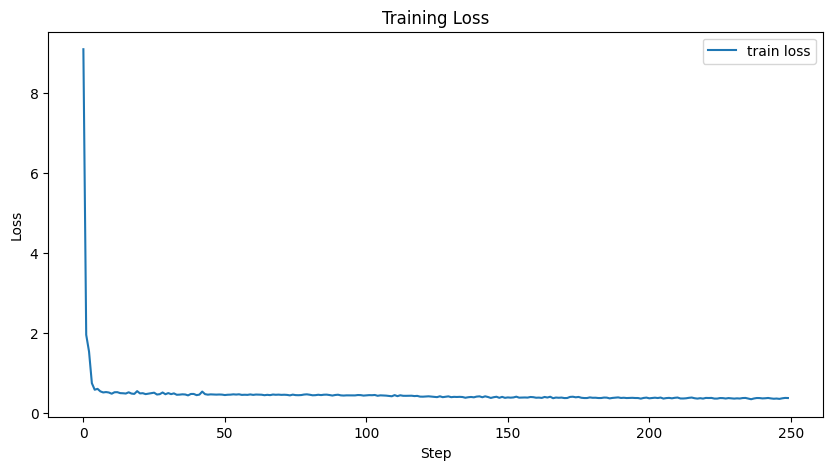

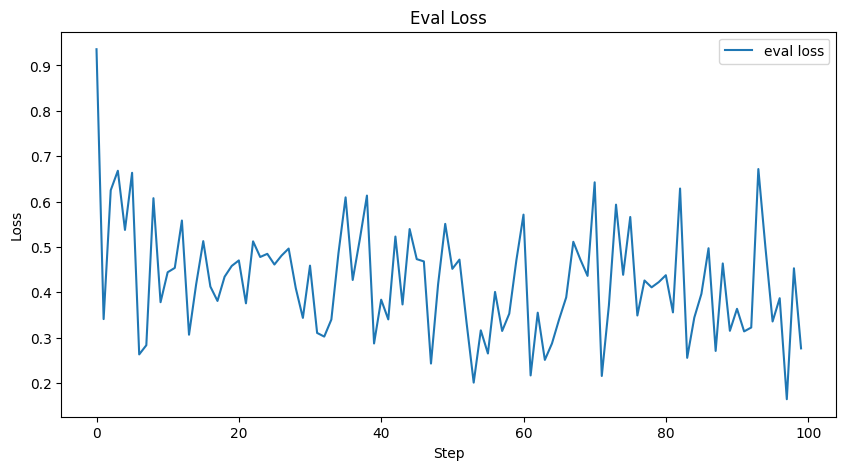

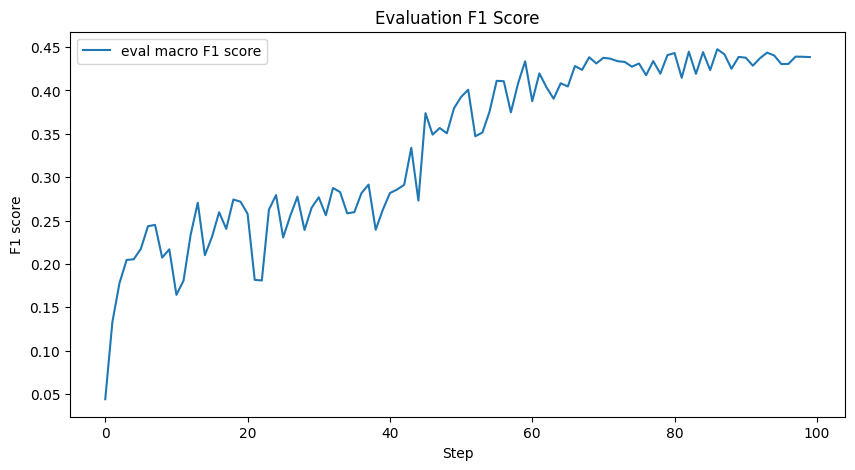

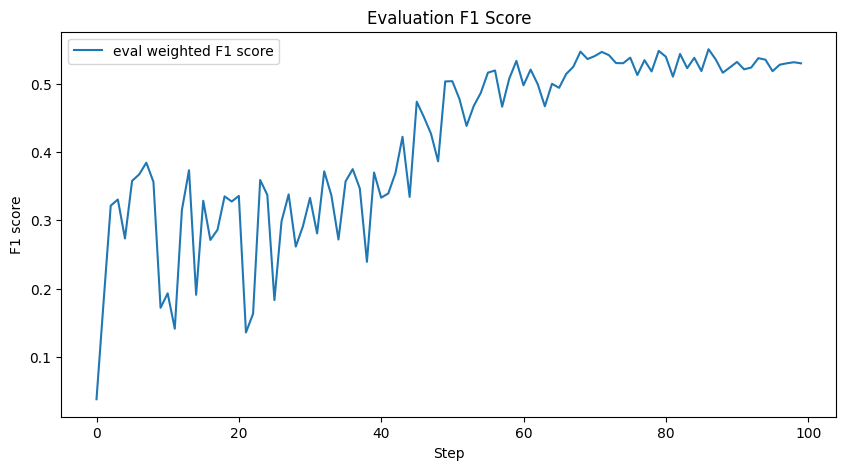

In [11]:
# draw the training and evaluation loss
import matplotlib.pyplot as plt
# smooth training loss
avg_num = 100
train_loss_list_smooth = [sum(train_loss_list[begin_idx:begin_idx+avg_num])/len(train_loss_list[begin_idx:begin_idx+avg_num]) for begin_idx in range(0, len(train_loss_list), avg_num)]
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list_smooth, label="train loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(eval_loss_list, label="eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Eval Loss")
plt.legend()
plt.show()

# draw the evaluation F1 score
plt.figure(figsize=(10, 5))
plt.plot(eval_F1_score_list_macro, label="eval macro F1 score")
plt.xlabel("Step")
plt.ylabel("F1 score")
plt.title("Evaluation F1 Score")
plt.legend()
plt.show()

# draw the evaluation F1 score
plt.figure(figsize=(10, 5))
plt.plot(eval_F1_score_list_weighted, label="eval weighted F1 score")
plt.xlabel("Step")
plt.ylabel("F1 score")
plt.title("Evaluation F1 Score")
plt.legend()
plt.show()


# ELSE

# ProgressiveDialogueDataset Class (not used for now)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import bisect


class ProgressiveDialogueDataset(Dataset):
    def __init__(self, dialogue_data, utterance_name="UtteranceID", emotion_name="EmotionID", max_length=None, utterance_padding_token_id=0, query_id=7, num_virtual_tokens=20):
        """
        Args:
            dialogue_data: A list of lists, where each inner list contains sentences
                           from one dialogue.
        """
        self.utterances = dialogue_data[utterance_name]
        self.emotions = dialogue_data[emotion_name]

        if max_length is None:
            max_length=0
            for utts in self.utterances:
                length = 0
                for utt in utts:
                    length += utt.shape[-1]+num_virtual_tokens
                if length > max_length:
                    max_length = length
        self.max_length = max_length

        self.query_id = query_id
        self.utterance_padding_token_id = utterance_padding_token_id
        self.num_virtual_tokens = num_virtual_tokens


        self.cumulative_sentence_counts = []
        self.row_lengths = [len(row) for row in self.utterances]
        self.total_sentences = 0
        for length in self.row_lengths:
            self.total_sentences += length
            self.cumulative_sentence_counts.append(self.total_sentences)

    def __len__(self):
        return self.total_sentences

    def __getitem__(self, idx):

        # Find which row this index belongs to
        row_index = bisect.bisect_right(self.cumulative_sentence_counts, idx)

        # Find the index of the sentence within that row
        sentence_index = idx - self.cumulative_sentence_counts[row_index]

        # Get the progressive sequence of sentences, save space for virtual tokens and concatenate every sentence
        utterances = self.utterances[row_index][:sentence_index + 1]
        utterance_lengths = [utt.shape[-1] for utt in utterances]

        # calculate the desired length of the utterance
        begin_index = len(utterance_lengths)
        cumulative_length = 0
        for i in range(len(utterance_lengths)-1,0-1, -1):
            # add virtual token space to the beginning of the sentence
            utterances[i] = torch.cat([ torch.full((self.num_virtual_tokens,), self.utterance_padding_token_id, dtype=torch.long), 
                                        utterances[i]], dim=1)
            cumulative_length += utterance_lengths[i]+self.num_virtual_tokens
            if cumulative_length > self.max_length:
                break
            begin_index = i
        # concatenate the sentences
        if begin_index == len(utterance_lengths):
            # if the first sentence is too long, we need to truncate it
            utterance = utterances[-1][:self.max_length]
            emotions = [self.query_id]
            attention_mask = torch.ones((self.max_length,), dtype=torch.long)

        else:
            utterance = torch.cat(utterances[begin_index:], dim=1)
            emotions = self.emotions[row_index][begin_index:sentence_index]
            emotions = emotions + [self.query_id]
            attention_mask = torch.ones((utterance.shape[-1],), dtype=torch.long)
            attention_mask = torch.cat([attention_mask, torch.zeros((self.max_length - utterance.shape[-1],), dtype=torch.long)], dim=1)
            utterance = torch.cat([utterance, torch.full((self.max_length - utterance.shape[-1],), self.utterance_padding_token_id, dtype=torch.long)], dim=1)

        labels = self.emotions[row_index][sentence_index]

        return {
            "UtteranceID": utterance,
            "EmotionID": emotions,
            "AttentionMask": attention_mask,
            "Label": labels,
        }




# T5-Large

## train

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

In [ ]:
correct = 0
total = 0
for pred, true in zip(eval_preds, dataset["validation"]["text_label"]):
    if pred.strip() == true.strip():
        correct += 1
    total += 1
accuracy = correct / total * 100
print(f"{accuracy=} % on the evaluation dataset")
print(f"{eval_preds[:10]=}")
print(f"{dataset['validation']['text_label'][:10]=}")

# Llama-4

In [ ]:
# Apply prefix tuning to solve the emotion recognition task
# First, do the language modeling task with prefix tuning
# The prefix are the emotions in the dataset, and the model will learn to predict the next word based on the prefix
# There's also an additional prefix for answering the emotion recognition task.


model_id = "meta-llama/Llama-4-Scout-17B-16E-Instruct"

processor = AutoProcessor.from_pretrained(model_id)
model = Llama4ForConditionalGeneration.from_pretrained(
    model_id,
    attn_implementation="flex_attention",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": train_df["Emotion"][0]},
            {"type": "text", "text": train_df["Utterance"][0]},
        ]
    },
]
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
)
# def get_data_loader(df, processor, max_length=128, batch_size=4):
#     """
#     Create a DataLoader for the dataset.
#     """
#     def encode(examples):
#         return processor(
#             examples["Emotion"],
#             examples["Utterance"],
#             truncation=True,
#             max_length=max_length,
#             padding="max_length",
#         )

#     # Encode the dataset
#     encoded_dataset = df.apply(encode, axis=1).tolist()
    
#     # Create DataLoader
#     data_loader = DataLoader(
#         encoded_dataset,
#         batch_size=batch_size,
#         collate_fn=default_data_collator
#     )
    
#     return data_loader

